In [1]:
#  Name:         Tom Bresee
#  Purpose:      EDA pt I 
#  Dataset:      Base Dataset
#  Status:       Normalized (but with no location features)
#  Project:      Capstone
#  Unversity:    Michigan
#  Comments:     This notebook includes data cleaning as well, to 
#                explain how the features play out

<br>

<br>

*View this notebook online via this link as well (easy to see, especially on smartphone)*

> [HTML View](https://htmlpreview.github.io/?https://raw.githubusercontent.com/mcmanus-git/Singapore-HDB/main/tom/final_notebooks/nb_EDA_pt_I_of_II.html)

<br>

*Utility Functions:*

In [2]:

def my_columns(df):
    """Print out columns from input dataframe"""
    for col in df.columns:
        print(col)
              
            
def my_null_per_col(column_name):
    print(df[column_name].isna().sum())
      
        
def my_null_all():
    """NaN for entire dataframe"""
    print(df.isna().sum())
    
    
def my_dup_rows_count():
    print(df.duplicated().sum())  
    # 1863 ? 
    
    
def kill_kolumns(list_of_columns):
    df.drop(list_of_columns, axis=1, inplace=True) 
    
    
def is_categorical(col):
    return df[col].dtype.name == 'object'


def quick_vc_bar(col):
    """ 
    input column
    output histogram of counts
    """
    print('\nValue Counts Histogram:', col)
    df[col].value_counts().plot(kind='bar', 
                                color = 'xkcd:lightish blue',
                                # color = 'navy',
                                # alpha=0.6,
                                figsize=(8,6));
    

def replace_values_in_col(col, mapping_dict):
    replace_values = mapping_dict
    df = df.replace({col: replace_values})

    
def the_columns(df):
    """sorted list of df columns"""
    for c in sorted(list(df.columns)):
        print(c)
        

def encode_and_bind(my_original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(my_original_dataframe[[feature_to_encode]])
    resulting_df = pd.concat([my_original_dataframe, dummies], axis=1)
    return(resulting_df)


*Libraries:*

In [3]:
# from mycreds import Capstone_AWS_RO
from mycreds import * 
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format) 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import glob  
from datetime import datetime as dt
import pandas_profiling
from pandas_profiling import ProfileReport
# from bokeh.layouts import column
# from bokeh.models import Div, TeX
# from bokeh.plotting import figure, show
# from bokeh.io import output_notebook
from sqlalchemy import create_engine
# output_notebook() # bokeh
from sklearn.model_selection import train_test_split, KFold, cross_val_score 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, recall_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import explained_variance_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
cm = sns.light_palette("blue", as_cmap=True)
# correlations.style.set_caption('Correlation Values Ranked').background_gradient(cmap=cm)
# import shap
# shap.initjs()
# careful with this ! ~ ~ ~ 
import seaborn as sns
# sns.set(rc={"figure.dpi":90, 'savefig.dpi':300})
sns.set_context('notebook')
# sns.set_style("whitegrid")
sns.set_style("ticks")
import matplotlib_inline.backend_inline
from IPython.display import set_matplotlib_formats
import matplotlib
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
# set_matplotlib_formats('retina')
plt.rcParams['savefig.facecolor']='white'

In [4]:
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

In [5]:
%matplotlib inline

*Download raw data from AWS database:*

```
Database Views:
resale_price_norm  - transactions WITHOUT location features
resale_location_features  - transactions WITH location features
```

In [6]:
query = 'select * from resale_price_norm;'
# engine = create_engine(f'postgresql+psycopg2://{Capstone_AWS_RO.username}:{Capstone_AWS_RO.password}@{Capstone_AWS_RO.host}/Capstone', echo=False)
# engine = create_engine(f'postgresql+psycopg2://{Capstone_AWS_RO.username}:{Capstone_AWS_RO.password}@{Capstone_AWS_RO.host}/Capstone', echo=False)
# - original - 
engine = create_engine(f'postgresql+psycopg2://{creds_tom.username}:{creds_tom.password}@{creds_tom.host}/Capstone', echo=False)
sql_alc_cnxn = engine.connect()

In [7]:
df = pd.read_sql(query, sql_alc_cnxn)  

In [8]:
original_number_of_observations = len(df)

In [9]:
original_number_of_observations

867677

In [10]:
len(df)  # ~ 867,677

867677

*Pickle if you want (in case no access to DB):*

In [11]:
# df.to_pickle('resale_price_norm_GOLD.pkl')  # ~ 232 MB
# compression  {‘infer’, ‘gzip’, ‘bz2’, ‘zip’, ‘xz’, None}
# will overwrite old file fyi 

*Read in previously downloaded .pkl of entire raw dataset, if desired:*

In [12]:
# new_df = pd.read_pickle('resale_price_norm_GOLD.pkl')  

In [13]:
len(df.columns)  # ~ 27 columns/features

27

*Storing raw data (unfiltered) in zipped (.csv embedded) form:*

In [14]:
#  compression_opts = dict(method='zip', 
#                         archive_name='resale_price_norm_GOLD.csv')

#  df.to_csv('resale_price_norm_GOLD.zip', 
#           index=False, 
#           compression=compression_opts)

The full exported data to .csv is a large file: 270 MB. Even when the file is compressed (.zip) it is still: ~ 83 MB. 

**Note** - *All resale values will be plotted in their normalized values*

*Storing raw data (unfiltered) in parquet form:*

In [15]:
#  df.to_parquet('df.parquet.gzip', compression='gzip') 
#  s3_url = 's3://bucket/folder/bucket.parquet.gzip'  
#  s3 bucket works as well

#  df.to_parquet(s3_url, compression='gzip')

In [16]:
# df.to_parquet('resale_price_norm_GOLD.parquet.gzip', compression='gzip')  
# parquet + compressed gzip form in the event files are huge
# and then can use: pd.read_parquet('df.parquet.gzip') to read the contents...

In [17]:
#  df.to_parquet('resale_price_norm_GOLD.parquet', engine='fastparquet')  
#  standard parquet form exported 

*Read-in parquet form (if needed):*

In [18]:
# IF you wanted to read, and its pretty darn fast:
#  tf = pd.read_parquet('resale_price_norm_GOLD.parquet', engine='fastparquet') 

*Quick checks:*

In [19]:
df.dtypes

transaction_id                               object
month                                datetime64[ns]
block                                        object
town                                         object
street_name                                  object
address                                      object
storey_range                                 object
storey_range_min                              int64
storey_range_max                              int64
flat_model                                   object
flat_type                                    object
n_rooms                                       int64
floor_area_sqm                              float64
lease_commence_date                           int64
remaining_lease                              object
remaining_lease_years                         int64
remaining_lease_months                      float64
resale_price                                float64
price_per_sq_ft                             float64
price_per_sq

In [20]:
df.head(1).T  # random example datapoint 

,0
transaction_id,2004_06_545_WOODLANDS_DR_16_07_TO_09
month,2004-06-01 00:00:00
block,545
town,WOODLANDS
street_name,WOODLANDS DR 16
address,545 WOODLANDS DR 16
storey_range,07 TO 09
storey_range_min,7
storey_range_max,9
flat_model,Model A


In [21]:
df.tail(1).T  # random example datapoint 

,867676
transaction_id,2004_06_546_WOODLANDS_DR_16_01_TO_03
month,2004-06-01 00:00:00
block,546
town,WOODLANDS
street_name,WOODLANDS DR 16
address,546 WOODLANDS DR 16
storey_range,01 TO 03
storey_range_min,1
storey_range_max,3
flat_model,Model A


*Timerange:*

In [22]:
df['month'] = pd.to_datetime(df['month']) 
df = df.sort_values(by='month', ascending=True).reset_index(drop=True) 

In [23]:
def data_timeframe(df):
    print('\nNumber of rows of data: ............ ',len(df))  
    print('Most historic datapoint date: ...... ', df.month.iloc[0])
    print('Most recent datapoint date: ........ ', df.month.iloc[-1])
    print('Number of days of data: ............ ',(df.month.iloc[-1]-df.month.iloc[0])) 
    
data_timeframe(df)

# Number of rows of data: ............  867677
# Most historic datapoint date: ......  1990-01-01 00:00:00
# Most recent datapoint date: ........  2022-03-01 00:00:00
# Number of days of data: ............  11747 days 00:00:00


Number of rows of data: ............  867677
Most historic datapoint date: ......  1990-01-01 00:00:00
Most recent datapoint date: ........  2022-03-01 00:00:00
Number of days of data: ............  11747 days 00:00:00


*Singapore specifics (data integrity check):*

In [24]:
planning_areas = pd.read_html('https://en.wikipedia.org/wiki/Planning_Areas_of_Singapore')[2]
planning_areas = planning_areas[['Name (English)', 'Region','Area (km²)', 'Population[7]', 'Density (/km²)']]
planning_areas.columns = ['Name', 'Region', 'Area_km2', 'Population', 'Density_per_km2']
planning_areas

,Name,Region,Area_km2,Population,Density_per_km2
0,Ang Mo Kio,North-East,13.94,163950,13400
1,Bedok,East,21.69,279380,13000
2,Bishan,Central,7.62,88010,12000
3,Boon Lay,West,8.23,30,3.6
4,Bukit Batok,West,11.13,153740,14000
5,Bukit Merah,Central,14.34,151980,11000
6,Bukit Panjang,West,8.99,139280,15000
7,Bukit Timah,Central,17.53,77430,4400
8,Central Water Catchment,North,37.15,*,*
9,Changi,East,40.61,1830,80.62


In [25]:
# https://en.wikipedia.org/wiki/Regions_of_Singapore
regions = pd.read_html('https://en.wikipedia.org/wiki/Regions_of_Singapore')[1]
regions.columns = ['Region', 'Regional Centre', 'Largest PA by area', 'Largest PA by population', 'Area(km²)', 
                   'Estimated Population', 'Populationdensity(/km²)', 'PlanningAreas']
regions

,Region,Regional Centre,Largest PA by area,Largest PA by population,Area(km²),Estimated Population,Populationdensity(/km²),PlanningAreas
0,Central Region,Central Area (de facto),Queenstown,Bukit Merah,132.70,922580,6952,22
1,East Region,Tampines,Changi,Bedok,93.10,685890,7367,6
2,North Region,Woodlands,Central Water Catchment,Woodlands,134.50,582330,4330,8
3,North-East Region,Seletar,North-Eastern Islands,Sengkang,103.90,930910,8960,9
4,West Region,Jurong East,Western Water Catchment,Jurong West,201.30,922540,4583,12
5,Total,NaN,NaN,NaN,665.50,4044250,6077,55


In [26]:
towns = pd.read_html('https://en.wikipedia.org/wiki/New_towns_of_Singapore')[0]

towns = towns[  ['Name (English/Malay)', 'Total area (km2)', 'Residential area (km2)', 
                 'Dwelling units', 'Projected ultimate', 'Population']]

towns.columns = ['Name', 'Total area (km2)', 'Residential area (km2)', 
                 'Dwelling units', 'Projected ultimate', 'Population']

towns

,Name,Total area (km2),Residential area (km2),Dwelling units,Projected ultimate,Population
0,Ang Mo Kio,6.38,2.83,50726,58000,138200
1,Bedok,9.37,4.18,62816,79000,187900
2,Bishan,6.90,1.72,20072,34000,61100
3,Bukit Batok,7.85,2.91,44285,54000,121400
4,Bukit Merah,8.58,3.12,54227,68000,141400
5,Bukit Panjang,4.89,2.19,35325,44000,118900
6,Choa Chu Kang,5.83,3.07,48900,62000,167200
7,Clementi,4.12,2.03,26730,39000,69500
8,Geylang,6.78,2.14,30892,50000,86000
9,Hougang,13.09,3.67,57272,72000,179700


In [27]:
estates = pd.read_html('https://en.wikipedia.org/wiki/New_towns_of_Singapore')[1]
estates = estates[['Name (English/Malay)', 'Dwelling units', 'Population']]
estates

,Name (English/Malay),Dwelling units,Population
0,Bukit Timah,2423,8100
1,Marine Parade,6537,20800
2,Central Area,9459,27200


*Cleaning:*

In [28]:
# mapping towns to individual region is possible, can remove later if don't need

In [29]:
sorted(regions.Region.unique()) 
# from scraped, as data integrity check ! 

['Central Region',
 'East Region',
 'North Region',
 'North-East Region',
 'Total',
 'West Region']

In [30]:
# mapping towns -> region 

town_to_region_mapper = pd.Series(planning_areas.Region.values,
                                  index=planning_areas.Name).to_dict()

town_to_region_mapper

{'Ang Mo Kio': 'North-East',
 'Bedok': 'East',
 'Bishan': 'Central',
 'Boon Lay': 'West',
 'Bukit Batok': 'West',
 'Bukit Merah': 'Central',
 'Bukit Panjang': 'West',
 'Bukit Timah': 'Central',
 'Central Water Catchment': 'North',
 'Changi': 'East',
 'Changi Bay': 'East',
 'Choa Chu Kang': 'West',
 'Clementi': 'West',
 'Downtown Core': 'Central',
 'Geylang': 'Central',
 'Hougang': 'North-East',
 'Jurong East': 'West',
 'Jurong West': 'West',
 'Kallang': 'Central',
 'Lim Chu Kang': 'North',
 'Mandai': 'North',
 'Marina East': 'Central',
 'Marina South': 'Central',
 'Marine Parade': 'Central',
 'Museum': 'Central',
 'Newton': 'Central',
 'North-Eastern Islands': 'North-East',
 'Novena': 'Central',
 'Orchard': 'Central',
 'Outram': 'Central',
 'Pasir Ris': 'East',
 'Paya Lebar': 'East',
 'Pioneer': 'West',
 'Punggol': 'North-East',
 'Queenstown': 'Central',
 'River Valley': 'Central',
 'Rochor': 'Central',
 'Seletar': 'North-East',
 'Sembawang': 'North',
 'Sengkang': 'North-East',
 'Seran

In [31]:
# already exists:  'Kallang': 'Central'
town_to_region_mapper['Central Area'] = 'Central'  # obviously
town_to_region_mapper['Kallang/Whampoa'] = 'Central'
# sometimes the Kallang/Whampoa are reversed in order... 

In [32]:
town_to_region_mapper  # note, will be longer than our unique towns

{'Ang Mo Kio': 'North-East',
 'Bedok': 'East',
 'Bishan': 'Central',
 'Boon Lay': 'West',
 'Bukit Batok': 'West',
 'Bukit Merah': 'Central',
 'Bukit Panjang': 'West',
 'Bukit Timah': 'Central',
 'Central Water Catchment': 'North',
 'Changi': 'East',
 'Changi Bay': 'East',
 'Choa Chu Kang': 'West',
 'Clementi': 'West',
 'Downtown Core': 'Central',
 'Geylang': 'Central',
 'Hougang': 'North-East',
 'Jurong East': 'West',
 'Jurong West': 'West',
 'Kallang': 'Central',
 'Lim Chu Kang': 'North',
 'Mandai': 'North',
 'Marina East': 'Central',
 'Marina South': 'Central',
 'Marine Parade': 'Central',
 'Museum': 'Central',
 'Newton': 'Central',
 'North-Eastern Islands': 'North-East',
 'Novena': 'Central',
 'Orchard': 'Central',
 'Outram': 'Central',
 'Pasir Ris': 'East',
 'Paya Lebar': 'East',
 'Pioneer': 'West',
 'Punggol': 'North-East',
 'Queenstown': 'Central',
 'River Valley': 'Central',
 'Rochor': 'Central',
 'Seletar': 'North-East',
 'Sembawang': 'North',
 'Sengkang': 'North-East',
 'Seran

In [33]:
towns.Name   
# reference from previously scraped data, as quick reference

0          Ang Mo Kio
1               Bedok
2              Bishan
3         Bukit Batok
4         Bukit Merah
5       Bukit Panjang
6       Choa Chu Kang
7            Clementi
8             Geylang
9             Hougang
10        Jurong East
11        Jurong West
12    Kallang/Whampoa
13          Pasir Ris
14            Punggol
15         Queenstown
16          Sembawang
17           Sengkang
18          Serangoon
19           Tampines
20          Toa Payoh
21          Woodlands
22             Yishun
Name: Name, dtype: object

In [34]:
df['town'] = df['town'].str.title() 
# df['town'] = df['town'].str.replace('/','_')

In [35]:
sorted(df.town.unique().tolist())  
# len(df.town.unique()) - >  27 unique towns 

['Ang Mo Kio',
 'Bedok',
 'Bishan',
 'Bukit Batok',
 'Bukit Merah',
 'Bukit Panjang',
 'Bukit Timah',
 'Central Area',
 'Choa Chu Kang',
 'Clementi',
 'Geylang',
 'Hougang',
 'Jurong East',
 'Jurong West',
 'Kallang/Whampoa',
 'Lim Chu Kang',
 'Marine Parade',
 'Pasir Ris',
 'Punggol',
 'Queenstown',
 'Sembawang',
 'Sengkang',
 'Serangoon',
 'Tampines',
 'Toa Payoh',
 'Woodlands',
 'Yishun']

In [36]:
len(df[df['town'] == 'Ang Mo Kio'])

49769

In [37]:
df.town.value_counts()

Tampines           76110
Yishun             65791
Bedok              63657
Jurong West        62893
Woodlands          61022
Ang Mo Kio         49769
Hougang            47589
Bukit Batok        41531
Choa Chu Kang      35505
Bukit Merah        32141
Pasir Ris          31638
Toa Payoh          29781
Sengkang           27797
Queenstown         27280
Geylang            26747
Clementi           26745
Bukit Panjang      25801
Kallang/Whampoa    25285
Jurong East        23673
Serangoon          21878
Bishan             20363
Punggol            16101
Sembawang          11745
Marine Parade       7672
Central Area        6706
Bukit Timah         2393
Lim Chu Kang          64
Name: town, dtype: int64

In [38]:
# create new feature `region`:

df['region']= df['town'].map(town_to_region_mapper)

# had to fix for two missed towns:
# df.region.isnull().sum()    31991
# find the null values for towns -> region mapping we missed...

# df[df['region'].isnull()].town.unique()
#   array(['Kallang/Whampoa', 'Central Area'], dtype=object)

# https://en.wikipedia.org/wiki/Central_Area,_Singapore#:~:text=Located%20in%20the%20south%2Deastern,defined%20by%20the%20Urban%20Redevelopment

In [39]:
df.region.isnull().sum()  # 0, so no missed town -> region mapping

0


Value Counts Histogram: region


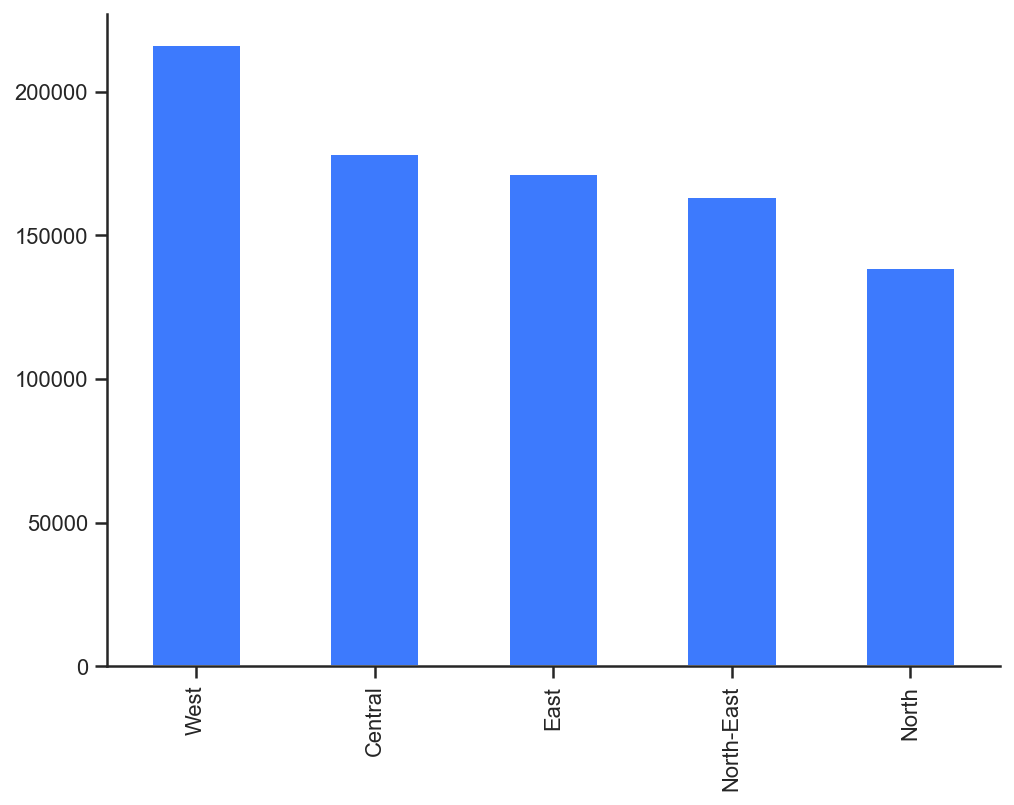

In [40]:
quick_vc_bar('region')

> Somewhat even distribution between regions. I believe it is important to map towns to region as part of this analysis.

In [41]:
df['flat_type'] = df['flat_type'].str.title() 

In [42]:
df.flat_type.unique().tolist() 
# 'Multi Generation' is the same as 'Multi-Generation' ?  i think so. 
# Need to figure out if 'Executive' is a suite, or is possible convert to 'floor' equivalent 

['5 Room',
 '3 Room',
 'Executive',
 '4 Room',
 '2 Room',
 '1 Room',
 'Multi Generation',
 'Multi-Generation']

In [43]:
df.flat_type.value_counts()

4 Room              326642
3 Room              281537
5 Room              181388
Executive            65876
2 Room               10421
1 Room                1285
Multi Generation       279
Multi-Generation       249
Name: flat_type, dtype: int64

In [44]:
df['flat_type'] = df['flat_type'].str.replace('Multi-Generation', 'Multi Generation', 
                                              regex=True) 

In [45]:
df.flat_type.unique().tolist() 

['5 Room',
 '3 Room',
 'Executive',
 '4 Room',
 '2 Room',
 '1 Room',
 'Multi Generation']

In [46]:
# link to explanation of flat types:
# https://sg.finance.yahoo.com/news/different-types-hdb-houses-call-020000642.html
# worth seeing if can modify forms 

In [47]:
df.flat_type.value_counts()

4 Room              326642
3 Room              281537
5 Room              181388
Executive            65876
2 Room               10421
1 Room                1285
Multi Generation       528
Name: flat_type, dtype: int64

In [48]:
df.flat_type.value_counts(normalize=True)

4 Room             0.38
3 Room             0.32
5 Room             0.21
Executive          0.08
2 Room             0.01
1 Room             0.00
Multi Generation   0.00
Name: flat_type, dtype: float64

In [49]:
#  **WARNING**:  this means that
#  Executive            65876
#  Multi Generation       528
#  won't have n_room count... which means that feature is odd... 

<br>

In [50]:
df.n_rooms.value_counts() 
# are there any NaNs ???
# i dont like this:  room count isn't mapped for some flat_types...
# watch missing values here... 

4    326642
3    281537
5    247792
2     10421
1      1285
Name: n_rooms, dtype: int64

In [51]:
df.n_rooms.value_counts(normalize=True) 

4   0.38
3   0.32
5   0.29
2   0.01
1   0.00
Name: n_rooms, dtype: float64

In [52]:
df.storey_range.unique().tolist()

['07 TO 09',
 '13 TO 15',
 '10 TO 12',
 '04 TO 06',
 '01 TO 03',
 '16 TO 18',
 '19 TO 21',
 '22 TO 24',
 '25 TO 27',
 '28 TO 30',
 '31 TO 33',
 '37 TO 39',
 '40 TO 42',
 '34 TO 36',
 '11 TO 15',
 '06 TO 10',
 '01 TO 05',
 '16 TO 20',
 '26 TO 30',
 '21 TO 25',
 '36 TO 40',
 '31 TO 35',
 '46 TO 48',
 '43 TO 45',
 '49 TO 51']

In [53]:
df.storey_range.value_counts()  
# note:  these are categories technically

04 TO 06    219080
07 TO 09    197527
01 TO 03    176124
10 TO 12    167727
13 TO 15     56326
16 TO 18     21490
19 TO 21     10245
22 TO 24      6660
25 TO 27      2905
01 TO 05      2700
06 TO 10      2474
28 TO 30      1277
11 TO 15      1259
31 TO 33       423
34 TO 36       392
37 TO 39       379
16 TO 20       265
40 TO 42       191
21 TO 25        92
43 TO 45        43
26 TO 30        39
46 TO 48        37
49 TO 51        13
36 TO 40         7
31 TO 35         2
Name: storey_range, dtype: int64

In [54]:
df.storey_range.value_counts(normalize=True)  
# high imbalance...

04 TO 06   0.25
07 TO 09   0.23
01 TO 03   0.20
10 TO 12   0.19
13 TO 15   0.06
16 TO 18   0.02
19 TO 21   0.01
22 TO 24   0.01
25 TO 27   0.00
01 TO 05   0.00
06 TO 10   0.00
28 TO 30   0.00
11 TO 15   0.00
31 TO 33   0.00
34 TO 36   0.00
37 TO 39   0.00
16 TO 20   0.00
40 TO 42   0.00
21 TO 25   0.00
43 TO 45   0.00
26 TO 30   0.00
46 TO 48   0.00
49 TO 51   0.00
36 TO 40   0.00
31 TO 35   0.00
Name: storey_range, dtype: float64

> high imbalance in flats to storey ranges

In [55]:
# adding new feature
df['storey_range_avg'] = (df['storey_range_min'] + df['storey_range_max'])/2
df['storey_range_avg'] = df['storey_range_avg']

In [56]:
sorted(list(df.columns))

['address',
 'block',
 'flat_model',
 'flat_type',
 'floor_area_sqm',
 'lease_commence_date',
 'month',
 'n_rooms',
 'price_per_sq_ft',
 'price_per_sq_ft_norm',
 'price_per_sq_ft_per_lease_yr',
 'price_per_sq_ft_per_lease_yr_norm',
 'price_per_sq_m',
 'price_per_sq_m_norm',
 'price_per_sq_m_per_lease_yr',
 'price_per_sq_m_per_lease_yr_norm',
 'region',
 'remaining_lease',
 'remaining_lease_months',
 'remaining_lease_years',
 'resale_price',
 'resale_price_norm',
 'storey_range',
 'storey_range_avg',
 'storey_range_max',
 'storey_range_min',
 'street_name',
 'town',
 'transaction_id']

In [57]:
df['flat_model'] = df['flat_model'].str.lower()
df['flat_model'] = df['flat_model'].str.title() 

In [58]:
sorted(df.flat_model.unique().tolist())
# we must assume these have many duplicated...
# i.e. IMPROVED actually equals Improved

# i dont like this. i feel like some of these apt types are 
# potentially subsets of other types of flat_models...
# consolidate somehow ? 

['2-Room',
 'Adjoined Flat',
 'Apartment',
 'Dbss',
 'Improved',
 'Improved-Maisonette',
 'Maisonette',
 'Model A',
 'Model A-Maisonette',
 'Model A2',
 'Multi Generation',
 'New Generation',
 'Premium Apartment',
 'Premium Apartment Loft',
 'Premium Maisonette',
 'Simplified',
 'Standard',
 'Terrace',
 'Type S1',
 'Type S2']

In [59]:
df.flat_model.value_counts()

Model A                   242085
Improved                  227608
New Generation            182187
Simplified                 55343
Standard                   41043
Premium Apartment          40331
Apartment                  33602
Maisonette                 28187
Model A2                    9486
Dbss                        2595
Model A-Maisonette          1974
Adjoined Flat               1155
Terrace                      670
Multi Generation             528
Type S1                      359
Type S2                      185
Improved-Maisonette          118
Premium Maisonette            85
Premium Apartment Loft        83
2-Room                        53
Name: flat_model, dtype: int64

In [60]:
df.flat_model.value_counts(normalize=True)

Model A                  0.28
Improved                 0.26
New Generation           0.21
Simplified               0.06
Standard                 0.05
Premium Apartment        0.05
Apartment                0.04
Maisonette               0.03
Model A2                 0.01
Dbss                     0.00
Model A-Maisonette       0.00
Adjoined Flat            0.00
Terrace                  0.00
Multi Generation         0.00
Type S1                  0.00
Type S2                  0.00
Improved-Maisonette      0.00
Premium Maisonette       0.00
Premium Apartment Loft   0.00
2-Room                   0.00
Name: flat_model, dtype: float64

In [61]:
sorted(list(df.lease_commence_date.unique()))

[1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019]

In [62]:
df.lease_commence_date.value_counts()

1985    84250
1984    61028
1988    48692
1987    41174
1978    39823
1986    37124
1989    30940
1980    30914
1979    29815
1997    29361
1993    26987
1996    26778
1998    24182
1983    22233
1976    20673
1981    20105
1977    19975
1999    19391
1992    19334
1995    18135
2001    17833
2000    16998
1975    16703
2003    14280
1974    14022
1982    12800
2002    11464
1970    10981
1990     8915
1973     8302
1969     8090
2004     7703
1971     7626
2015     7613
1994     6227
1967     5939
1972     5585
2016     4434
2013     4314
2012     4010
2005     3614
2014     2826
2006     2813
2017     2632
2011     2235
2008     1862
1968     1822
2009     1555
1991     1192
2010     1159
2007      836
2018      315
2019       33
1966       30
Name: lease_commence_date, dtype: int64

In [63]:
df.lease_commence_date.value_counts().sort_index(ascending=False)

2019       33
2018      315
2017     2632
2016     4434
2015     7613
2014     2826
2013     4314
2012     4010
2011     2235
2010     1159
2009     1555
2008     1862
2007      836
2006     2813
2005     3614
2004     7703
2003    14280
2002    11464
2001    17833
2000    16998
1999    19391
1998    24182
1997    29361
1996    26778
1995    18135
1994     6227
1993    26987
1992    19334
1991     1192
1990     8915
1989    30940
1988    48692
1987    41174
1986    37124
1985    84250
1984    61028
1983    22233
1982    12800
1981    20105
1980    30914
1979    29815
1978    39823
1977    19975
1976    20673
1975    16703
1974    14022
1973     8302
1972     5585
1971     7626
1970    10981
1969     8090
1968     1822
1967     5939
1966       30
Name: lease_commence_date, dtype: int64

*Drop Duplicate Rows (initial):*

In [64]:
df = df.drop_duplicates() # keep=False, inplace=True

In [65]:
len(df)  

865814

In [66]:
original_number_of_observations

867677

In [67]:
original_number_of_observations - len(df)

1863

In [68]:
sorted(df.columns.to_list())

['address',
 'block',
 'flat_model',
 'flat_type',
 'floor_area_sqm',
 'lease_commence_date',
 'month',
 'n_rooms',
 'price_per_sq_ft',
 'price_per_sq_ft_norm',
 'price_per_sq_ft_per_lease_yr',
 'price_per_sq_ft_per_lease_yr_norm',
 'price_per_sq_m',
 'price_per_sq_m_norm',
 'price_per_sq_m_per_lease_yr',
 'price_per_sq_m_per_lease_yr_norm',
 'region',
 'remaining_lease',
 'remaining_lease_months',
 'remaining_lease_years',
 'resale_price',
 'resale_price_norm',
 'storey_range',
 'storey_range_avg',
 'storey_range_max',
 'storey_range_min',
 'street_name',
 'town',
 'transaction_id']

*How many observations/datapoints by 'month':*

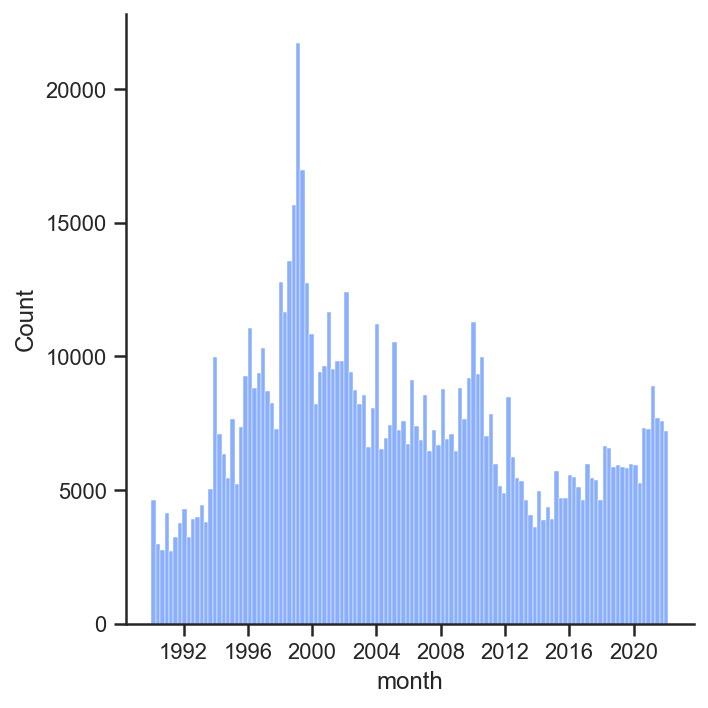

In [69]:
sns.displot(df['month'],color = 'xkcd:lightish blue', alpha=0.6); 

In [70]:
df.town.value_counts()

Tampines           75994
Yishun             65660
Bedok              63493
Jurong West        62727
Woodlands          60870
Ang Mo Kio         49620
Hougang            47521
Bukit Batok        41462
Choa Chu Kang      35458
Bukit Merah        32066
Pasir Ris          31579
Toa Payoh          29687
Sengkang           27739
Queenstown         27215
Geylang            26681
Clementi           26678
Bukit Panjang      25751
Kallang/Whampoa    25221
Jurong East        23624
Serangoon          21847
Bishan             20339
Punggol            16050
Sembawang          11728
Marine Parade       7650
Central Area        6698
Bukit Timah         2393
Lim Chu Kang          63
Name: town, dtype: int64


Value Counts Histogram: town


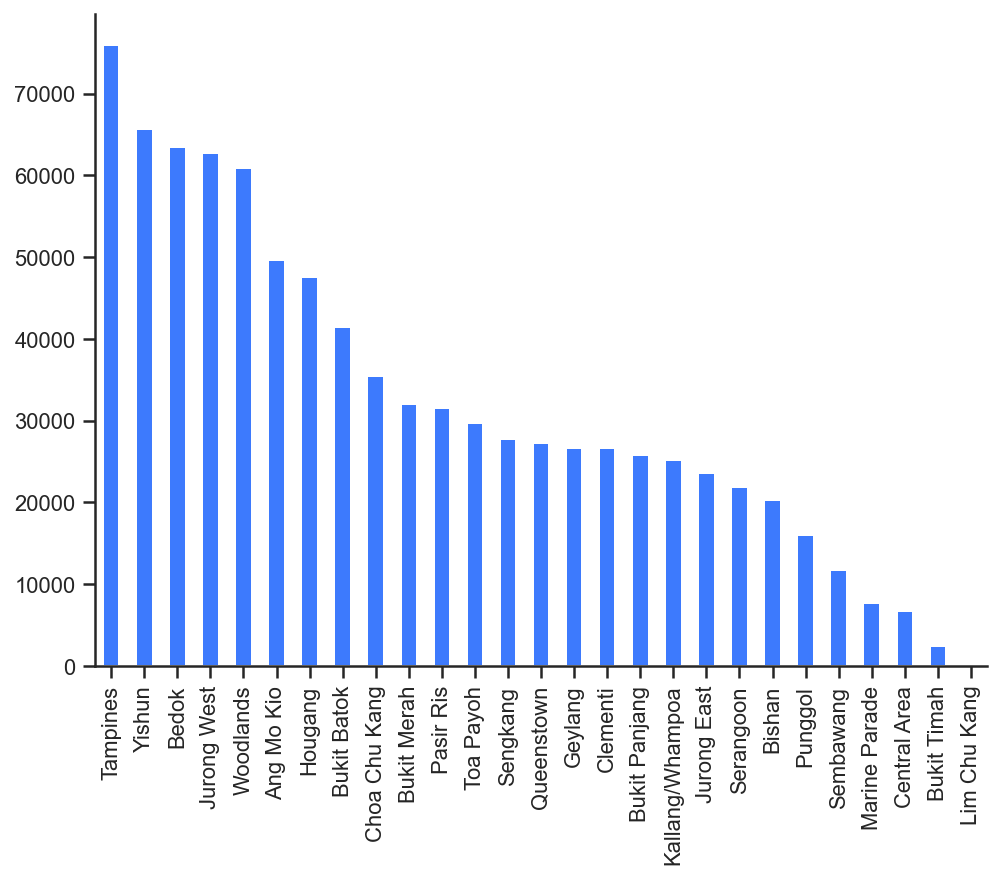

In [71]:
quick_vc_bar('town')

> There are four towns that have somewhat low observations

In [72]:
df.storey_range.value_counts()

04 TO 06    218530
07 TO 09    197105
01 TO 03    175819
10 TO 12    167353
13 TO 15     56211
16 TO 18     21443
19 TO 21     10217
22 TO 24      6650
25 TO 27      2900
01 TO 05      2696
06 TO 10      2472
28 TO 30      1277
11 TO 15      1259
31 TO 33       423
34 TO 36       391
37 TO 39       379
16 TO 20       265
40 TO 42       191
21 TO 25        92
43 TO 45        43
26 TO 30        39
46 TO 48        37
49 TO 51        13
36 TO 40         7
31 TO 35         2
Name: storey_range, dtype: int64

> Watch out:  there are ranges of storeys like 01 to 05 and also 01 to 03...


Value Counts Histogram: storey_range


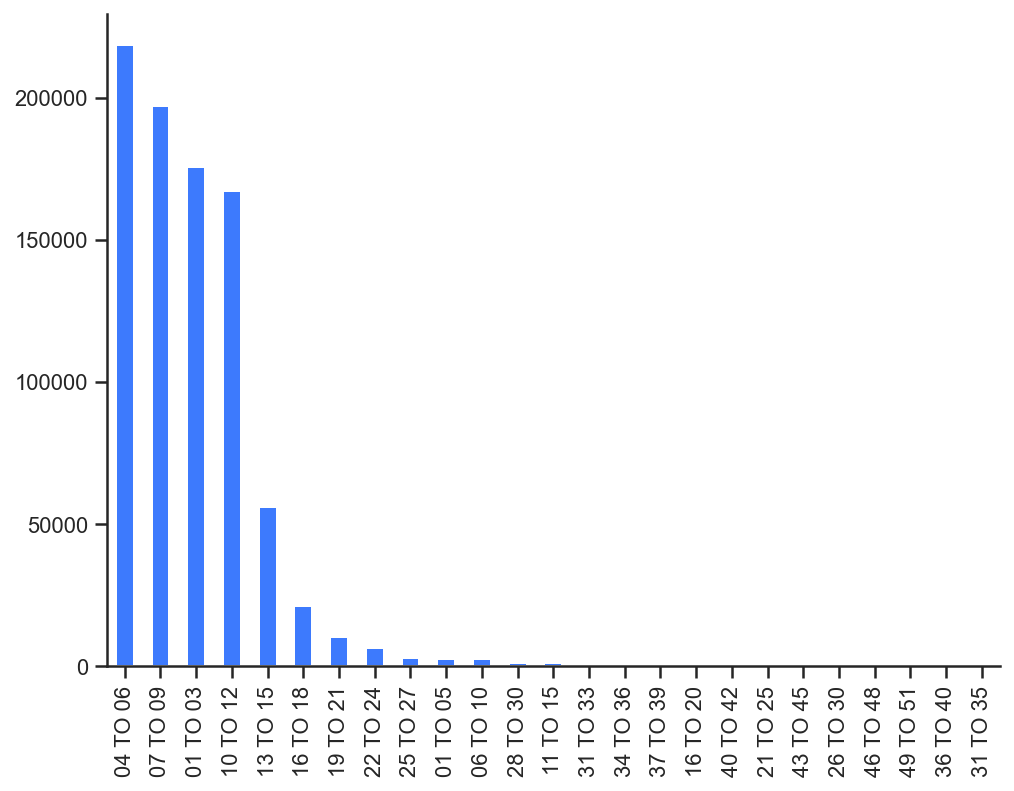

In [73]:
plt.figure(figsize=(10,6))
quick_vc_bar('storey_range'); 

> There are four storey ranges that seem to encompass the vast majority... 04-06, 07-09, 01-03, and 10-12...

*High-Level EDA:*

In [74]:
display(df.describe())

,storey_range_min,storey_range_max,n_rooms,floor_area_sqm,lease_commence_date,remaining_lease_years,remaining_lease_months,resale_price,price_per_sq_ft,price_per_sq_m,price_per_sq_ft_per_lease_yr,price_per_sq_m_per_lease_yr,resale_price_norm,price_per_sq_ft_norm,price_per_sq_ft_per_lease_yr_norm,price_per_sq_m_norm,price_per_sq_m_per_lease_yr_norm,storey_range_avg
count,865814.00,865814.00,865814.00,865814.00,865814.00,865814.00,158351.00,865814.00,865814.00,865814.00,865814.00,865814.00,865814.00,865814.00,865814.00,865814.00,865814.00,865814.00
mean,6.60,8.62,3.93,95.71,1987.63,81.00,4.24,303798.94,955.04,3133.33,12.23,40.13,489577.55,1536.88,19.27,5042.25,63.23,7.61
std,4.72,4.72,0.82,25.96,9.97,10.18,3.83,156210.92,413.97,1358.18,6.17,20.25,192127.34,337.55,4.89,1107.46,16.05,4.72
min,1.00,3.00,1.00,28.00,1966.00,43.00,0.00,5000.00,49.16,161.29,0.59,1.94,24587.76,241.75,2.95,793.15,9.67,2.00
25%,4.00,6.00,3.00,73.00,1980.00,74.00,0.00,186000.00,687.42,2255.32,8.18,26.84,345125.00,1320.89,15.97,4333.62,52.39,5.00
50%,7.00,9.00,4.00,93.00,1986.00,83.00,4.00,283000.00,867.14,2844.96,10.47,34.34,460032.15,1487.48,18.26,4880.20,59.92,8.00
75%,10.00,12.00,5.00,113.00,1995.00,89.00,8.00,395000.00,1198.49,3932.04,15.43,50.63,584088.05,1692.16,21.60,5551.72,70.88,11.00
max,49.00,51.00,5.00,307.00,2019.00,101.00,11.00,1360000.00,3932.90,12903.23,65.63,215.31,1792857.14,4441.42,74.17,14571.59,243.34,50.00


In [75]:
# a clearer representation 
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
storey_range_min,865814.00,6.60,4.72,1.00,4.00,7.00,10.00,49.00
storey_range_max,865814.00,8.62,4.72,3.00,6.00,9.00,12.00,51.00
n_rooms,865814.00,3.93,0.82,1.00,3.00,4.00,5.00,5.00
floor_area_sqm,865814.00,95.71,25.96,28.00,73.00,93.00,113.00,307.00
lease_commence_date,865814.00,1987.63,9.97,1966.00,1980.00,1986.00,1995.00,2019.00
remaining_lease_years,865814.00,81.00,10.18,43.00,74.00,83.00,89.00,101.00
remaining_lease_months,158351.00,4.24,3.83,0.00,0.00,4.00,8.00,11.00
resale_price,865814.00,303798.94,156210.92,5000.00,186000.00,283000.00,395000.00,1360000.00
price_per_sq_ft,865814.00,955.04,413.97,49.16,687.42,867.14,1198.49,3932.90
price_per_sq_m,865814.00,3133.33,1358.18,161.29,2255.32,2844.96,3932.04,12903.23


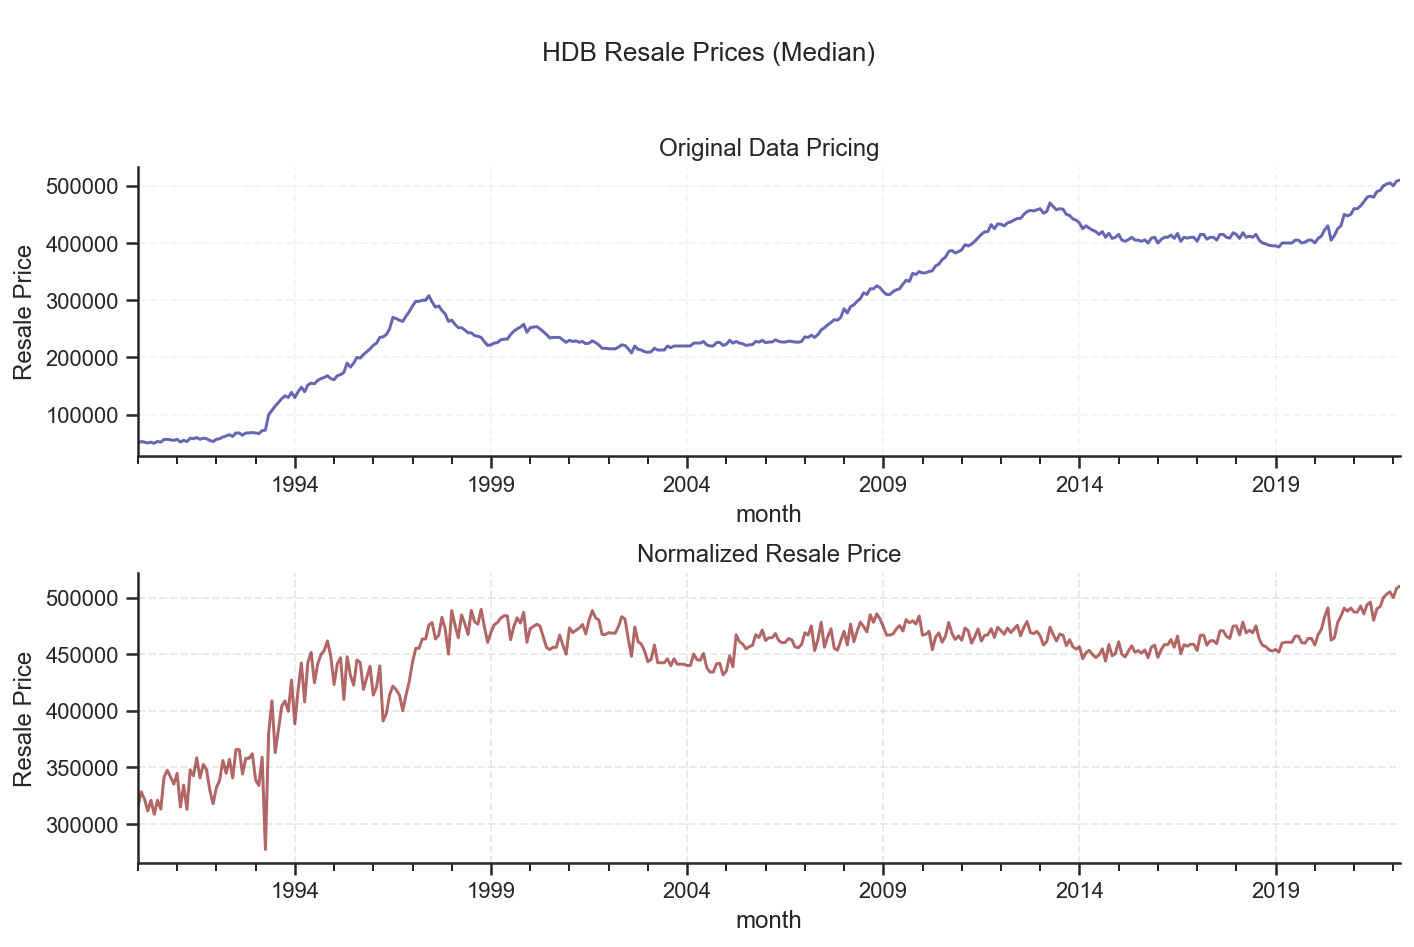

In [76]:
fig = plt.figure(figsize=(11,7))
fig.suptitle('\nHDB Resale Prices (Median)', fontsize=13)
ax1 = fig.add_subplot(211)
df.groupby('month')[['resale_price']].median().plot(ax=ax1, 
                                                    color='navy', 
                                                    alpha=0.6,
                                                    legend=None)
ax1.set_ylabel('Resale Price')
ax1.set_title('Original Data Pricing', size=12)
plt.grid(linestyle='--', alpha=0.2)


ax2 = fig.add_subplot(212)
df.groupby('month')[['resale_price_norm']].median().plot(ax=ax2, 
                                                         color='maroon', 
                                                         alpha=0.6,
                                                         legend=None)
ax2.set_ylabel('Resale Price')
ax2.set_title('Normalized Resale Price', size=12)
plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95]) 
plt.grid(linestyle='--', alpha=0.4)
plt.show();

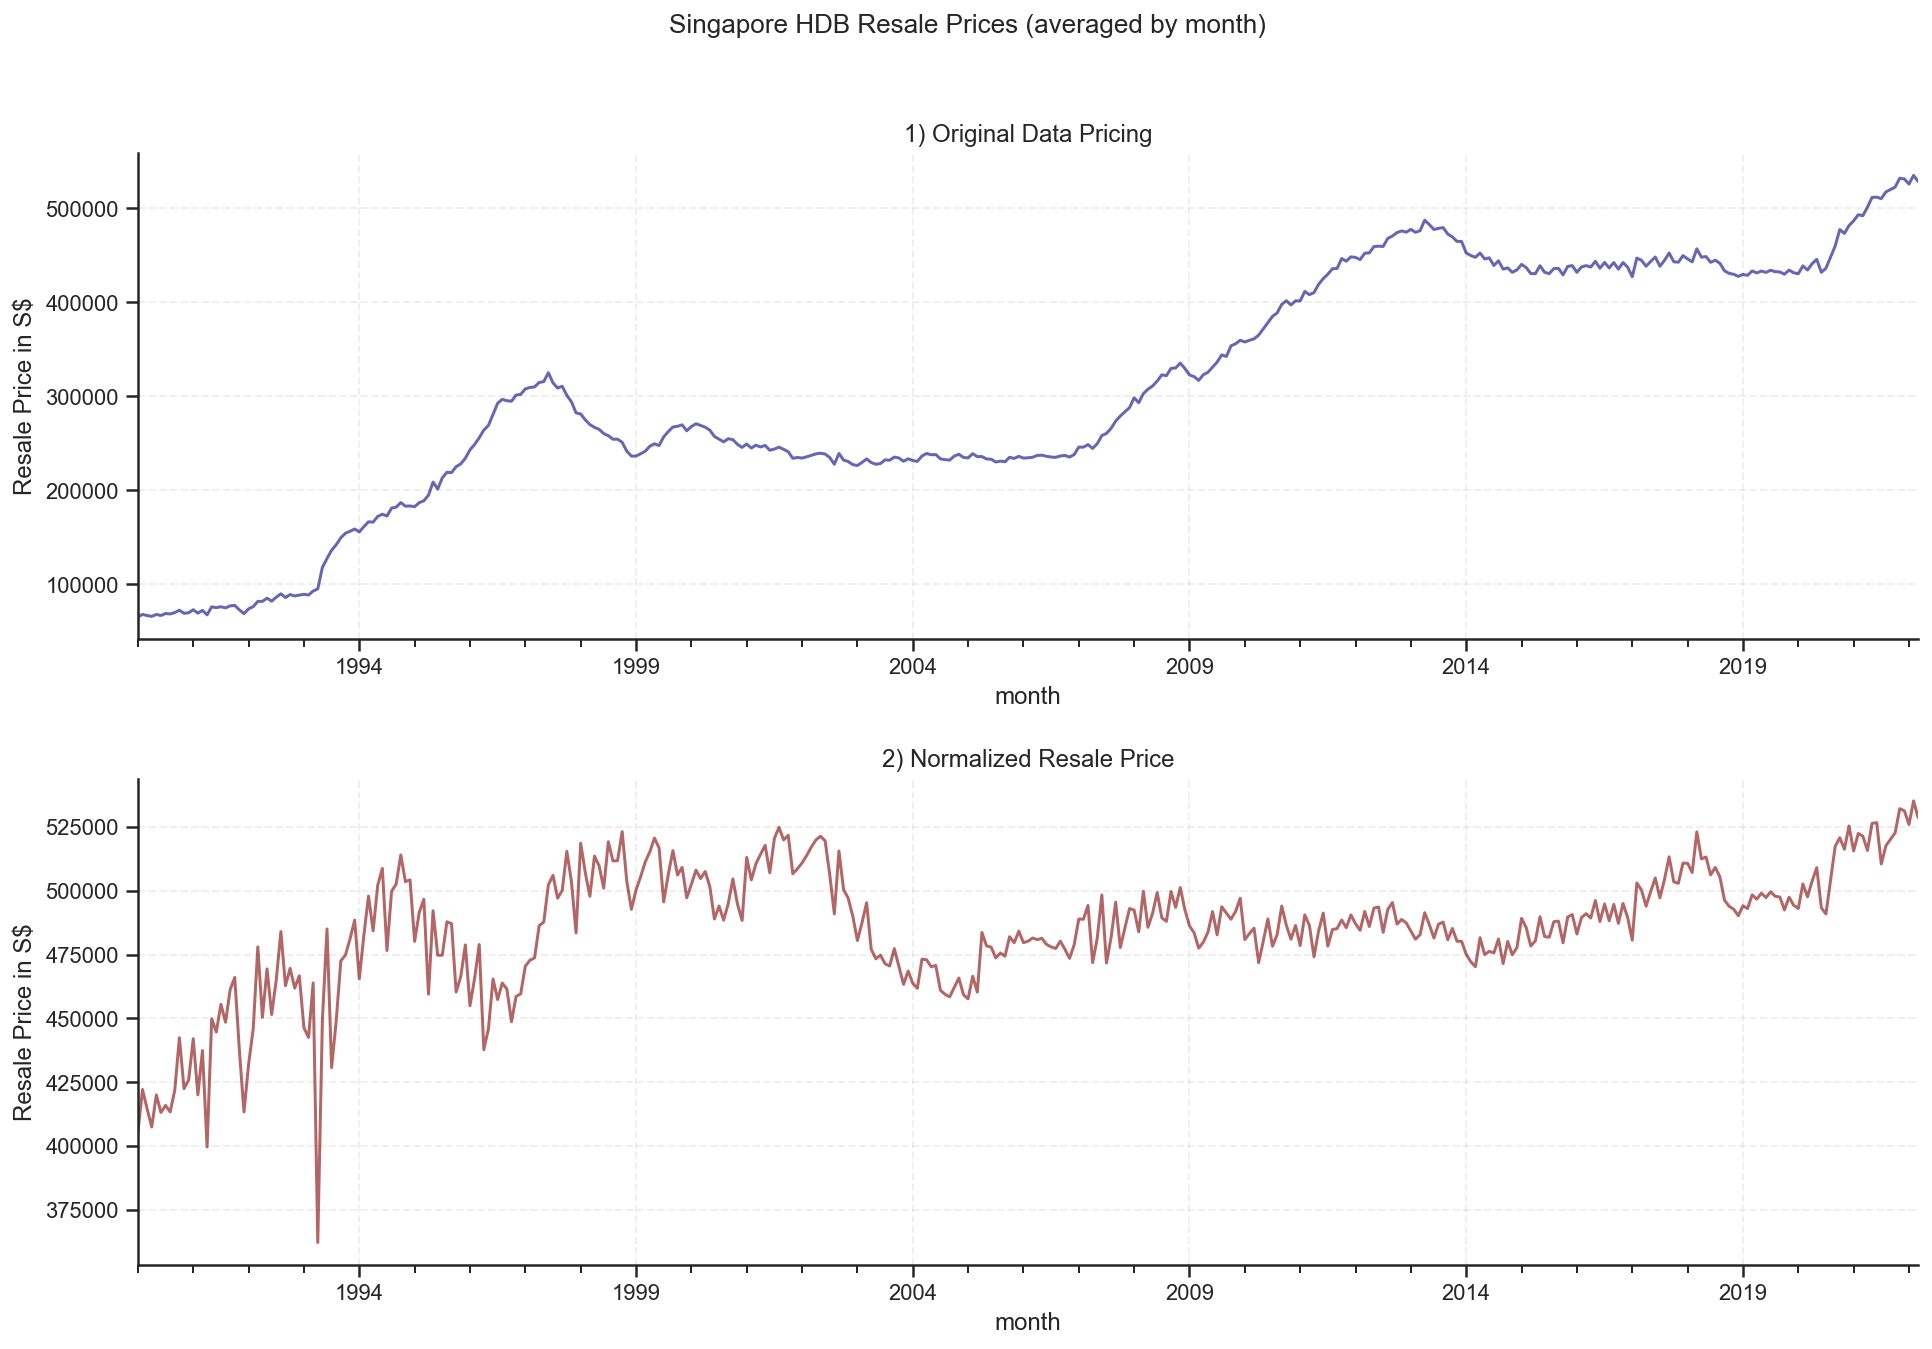

In [77]:

# making it hard core pretty

fig = plt.figure(figsize=(15,10))
fig.suptitle('Singapore HDB Resale Prices (averaged by month)', fontsize=13)
ax1 = fig.add_subplot(211)
df.groupby('month')[['resale_price']].mean().plot(ax=ax1, 
                                                    color='navy', 
                                                    alpha=0.6,
                                                    legend=None)

ax1.set_ylabel('Resale Price in S$')
ax1.set_title('1) Original Data Pricing', size=12)
plt.grid(linestyle='--', alpha=0.3)

ax2 = fig.add_subplot(212)
df.groupby('month')[['resale_price_norm']].mean().plot(ax=ax2, 
                                                         color='maroon', 
                                                         alpha=0.6,
                                                         legend=None)
ax2.set_ylabel('Resale Price in S$')
ax2.set_title('\n2) Normalized Resale Price', size=12)
plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95]) 
plt.grid(linestyle='--', alpha=0.3)

plt.savefig('pre_and_post_normalization.png', 
            bbox_inches='tight',
            pad_inches=0.3, 
            dpi=600); 

# plt.show();


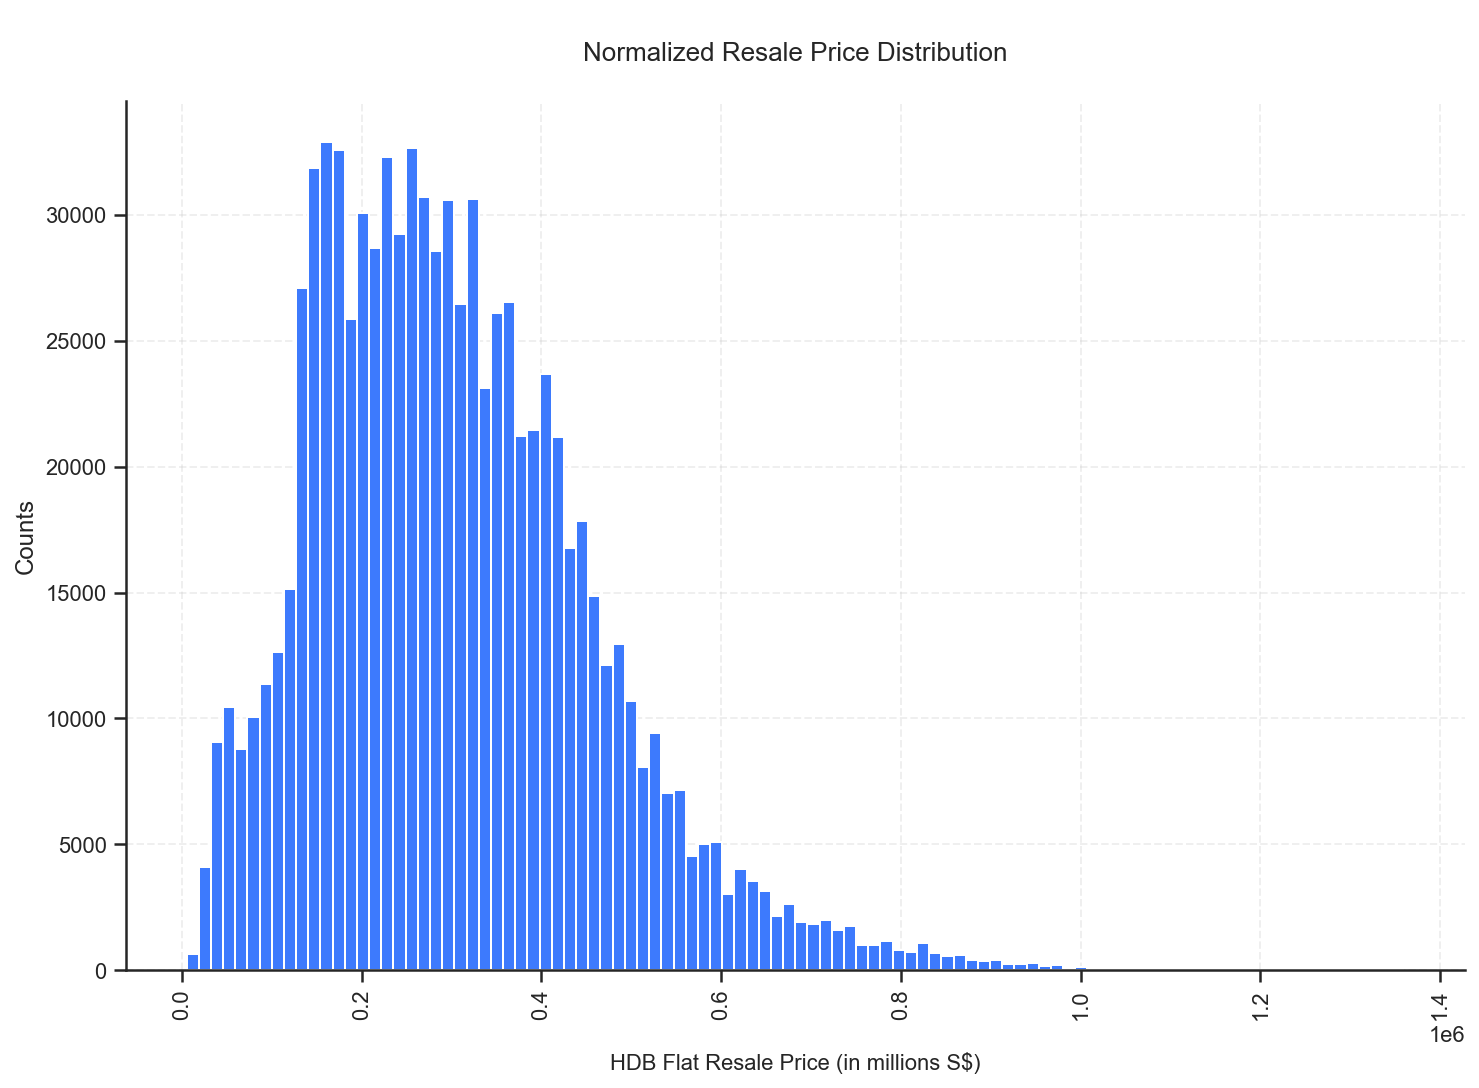

In [78]:
price = df['resale_price_norm'].nunique()
fig = plt.figure(figsize=(12,8))
plt.hist(df['resale_price'], 
         bins = 100, 
         color = 'xkcd:lightish blue'
         #alpha=0.6
         )
sns.despine()
plt.ylabel('Counts', fontsize=12)
plt.xlabel('\nHDB Flat Resale Price (in millions S$)', fontsize=11)
plt.xticks(rotation='vertical')
plt.title("\nNormalized Resale Price Distribution\n", fontsize=13)
plt.grid(linestyle='--', alpha=0.3)
plt.show(); 

# plt.savefig('hist_resale_prices.png', 
#             bbox_inches='tight',
#             pad_inches=0.2, 
#             dpi=400);

> This is left skewed, may make sense to do log transform later 

In [79]:
display(df.describe())

,storey_range_min,storey_range_max,n_rooms,floor_area_sqm,lease_commence_date,remaining_lease_years,remaining_lease_months,resale_price,price_per_sq_ft,price_per_sq_m,price_per_sq_ft_per_lease_yr,price_per_sq_m_per_lease_yr,resale_price_norm,price_per_sq_ft_norm,price_per_sq_ft_per_lease_yr_norm,price_per_sq_m_norm,price_per_sq_m_per_lease_yr_norm,storey_range_avg
count,865814.00,865814.00,865814.00,865814.00,865814.00,865814.00,158351.00,865814.00,865814.00,865814.00,865814.00,865814.00,865814.00,865814.00,865814.00,865814.00,865814.00,865814.00
mean,6.60,8.62,3.93,95.71,1987.63,81.00,4.24,303798.94,955.04,3133.33,12.23,40.13,489577.55,1536.88,19.27,5042.25,63.23,7.61
std,4.72,4.72,0.82,25.96,9.97,10.18,3.83,156210.92,413.97,1358.18,6.17,20.25,192127.34,337.55,4.89,1107.46,16.05,4.72
min,1.00,3.00,1.00,28.00,1966.00,43.00,0.00,5000.00,49.16,161.29,0.59,1.94,24587.76,241.75,2.95,793.15,9.67,2.00
25%,4.00,6.00,3.00,73.00,1980.00,74.00,0.00,186000.00,687.42,2255.32,8.18,26.84,345125.00,1320.89,15.97,4333.62,52.39,5.00
50%,7.00,9.00,4.00,93.00,1986.00,83.00,4.00,283000.00,867.14,2844.96,10.47,34.34,460032.15,1487.48,18.26,4880.20,59.92,8.00
75%,10.00,12.00,5.00,113.00,1995.00,89.00,8.00,395000.00,1198.49,3932.04,15.43,50.63,584088.05,1692.16,21.60,5551.72,70.88,11.00
max,49.00,51.00,5.00,307.00,2019.00,101.00,11.00,1360000.00,3932.90,12903.23,65.63,215.31,1792857.14,4441.42,74.17,14571.59,243.34,50.00


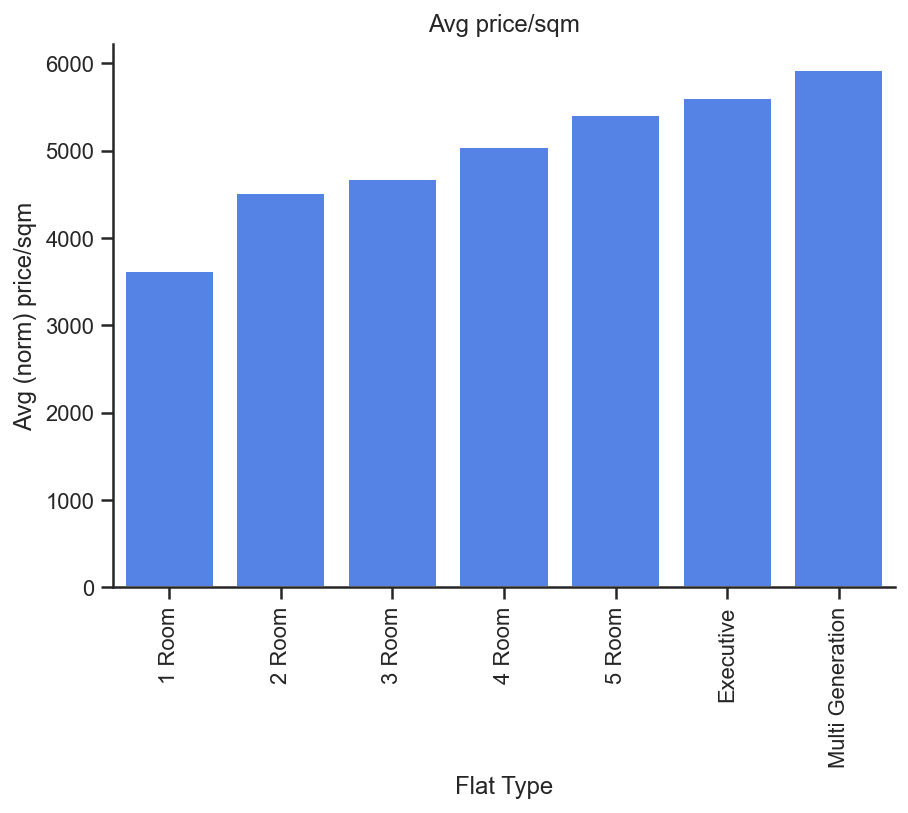

In [80]:
fig = plt.figure(figsize=(7,5))
flat_type = np.unique(df['flat_type'])
n = len(flat_type)
avg_price = np.zeros(n)
for i in range(0,n):
        price = df['resale_price_norm'][df['flat_type'] == flat_type[i]].sum()
        sqm = df['floor_area_sqm'][df['flat_type'] == flat_type[i]].sum()
        price_f = price/sqm
        avg_price[i] = price_f
sns.barplot(x=flat_type,y=avg_price, color = 'xkcd:lightish blue', alpha=1)
plt.ylabel('Avg (norm) price/sqm', fontsize=12)
plt.xlabel('Flat Type', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Avg price/sqm", fontsize=12)
plt.show(); 

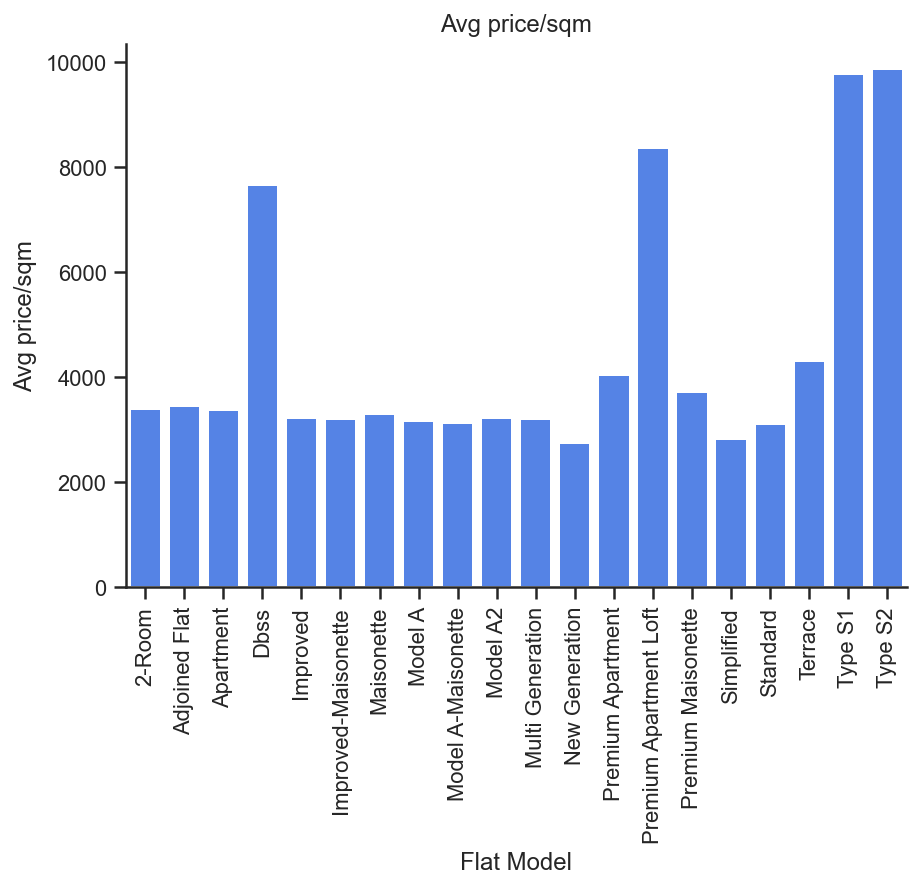

In [81]:
fig = plt.figure(figsize=(7,5))
flat_model = np.unique(df['flat_model'])
n = len(flat_model)
avg_price = np.zeros(n)
for i in range(0,n):
        price = df['resale_price'][df['flat_model'] == flat_model[i]].sum()
        sq_m = df['floor_area_sqm'][df['flat_model'] == flat_model[i]].sum()
        price_f= price/sq_m
        avg_price[i] = price_f
sns.barplot(x=flat_model,y=avg_price, color = 'xkcd:lightish blue', alpha=1)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('Flat Model', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Avg price/sqm", fontsize=12)
plt.show(); 


Value Counts Histogram: storey_range


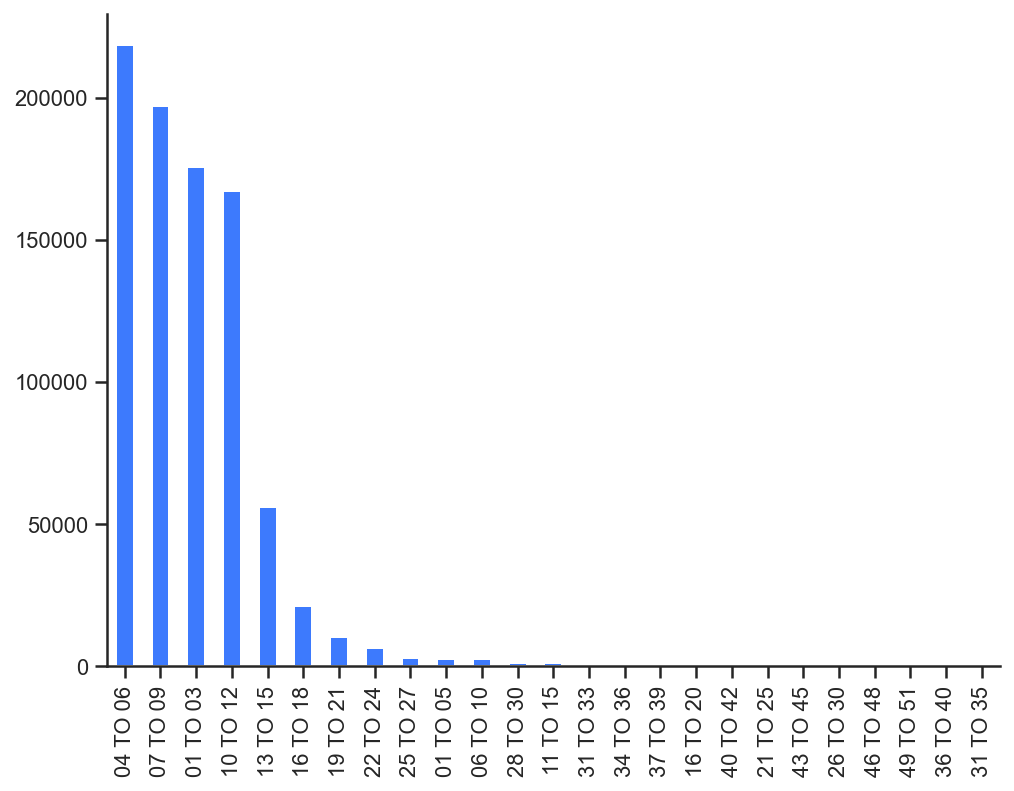

In [82]:
quick_vc_bar('storey_range'); 

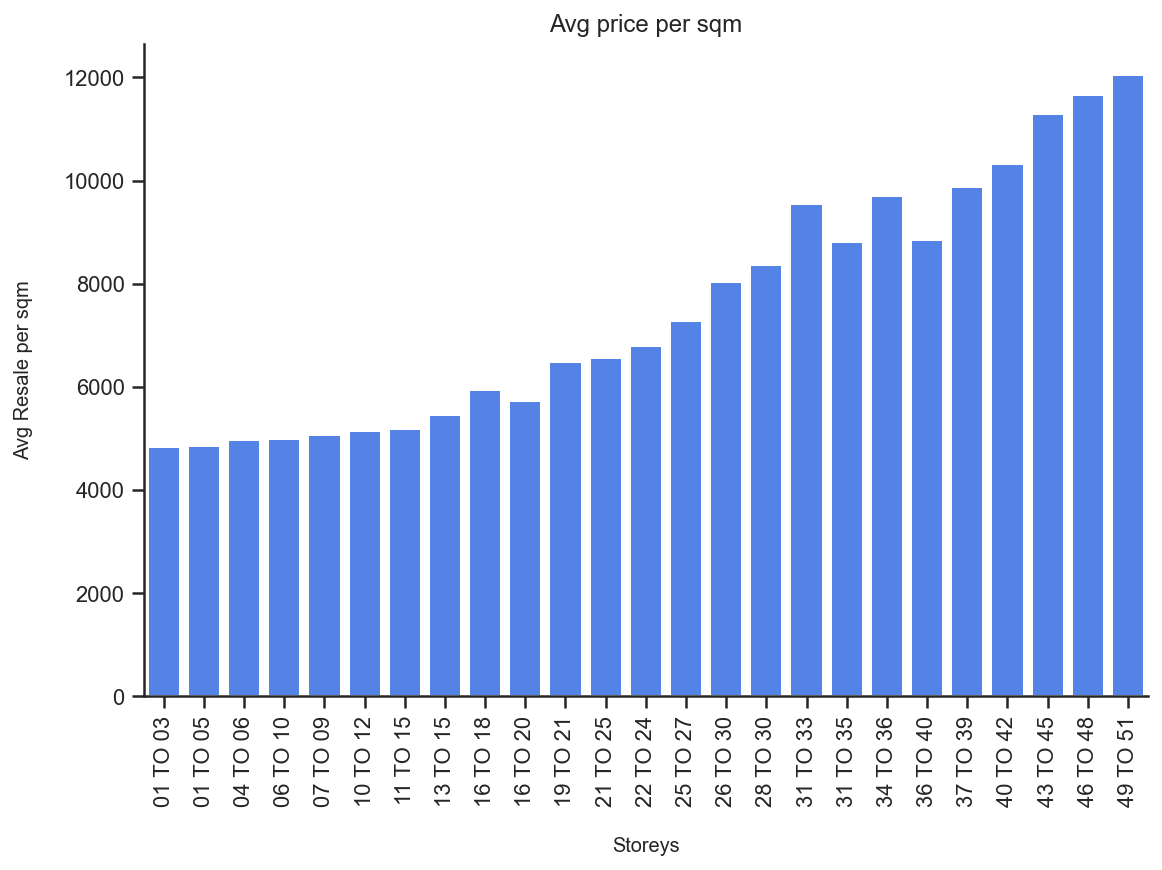

In [83]:
storeys = np.unique(df['storey_range'])
n = len(storeys)
avg_price = np.zeros(n)
for i in range(0,n):
        price = df['resale_price_norm'][df['storey_range'] == storeys[i]].sum()
        sqm = df['floor_area_sqm'][df['storey_range'] == storeys[i]].sum()
        price_f = price/sqm
        avg_price[i] = price_f
plt.figure(figsize=(9,6))
sns.barplot(x=storeys,
            y=avg_price, 
            color = 'xkcd:lightish blue', alpha=1)
plt.ylabel('Avg Resale per sqm\n', 
           fontsize=10)
plt.xlabel('\nStoreys',
           fontsize=10)
plt.xticks(rotation='vertical')
plt.title("Avg price per sqm",
          fontsize=12)
sns.despine()
plt.show();

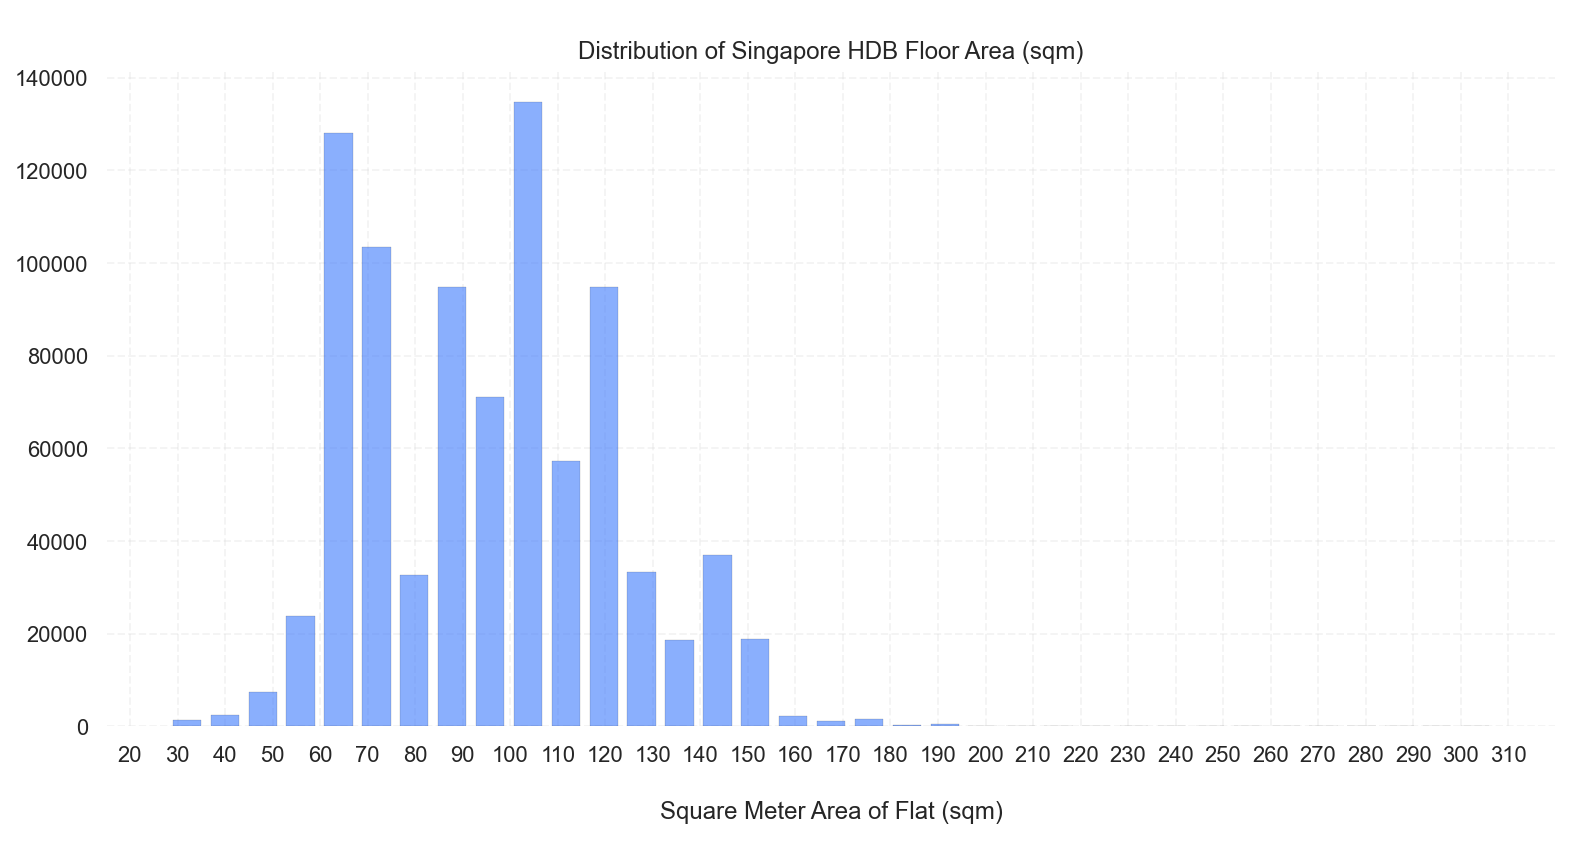

In [84]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(11,6))
sns.distplot(df['floor_area_sqm'], 
             kde=False, 
             color = 'xkcd:lightish blue', 
             kde_kws={'bw':4, "linewidth":.9, 'alpha':.6},
             hist_kws={"linewidth": .10, 'edgecolor':'black', 'alpha':.6, "rwidth":0.75},
             bins=35)    
sns.despine(top=True, right=True, left=True, bottom=True)
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
# ax.set_yticklabels([])
plt.title('\nDistribution of Singapore HDB Floor Area (sqm)',fontsize=12, loc="center")
ax.set(xlabel="\nSquare Meter Area of Flat (sqm)\n")
plt.grid(linestyle='--', alpha=0.2)
plt.tight_layout()
plt.show();

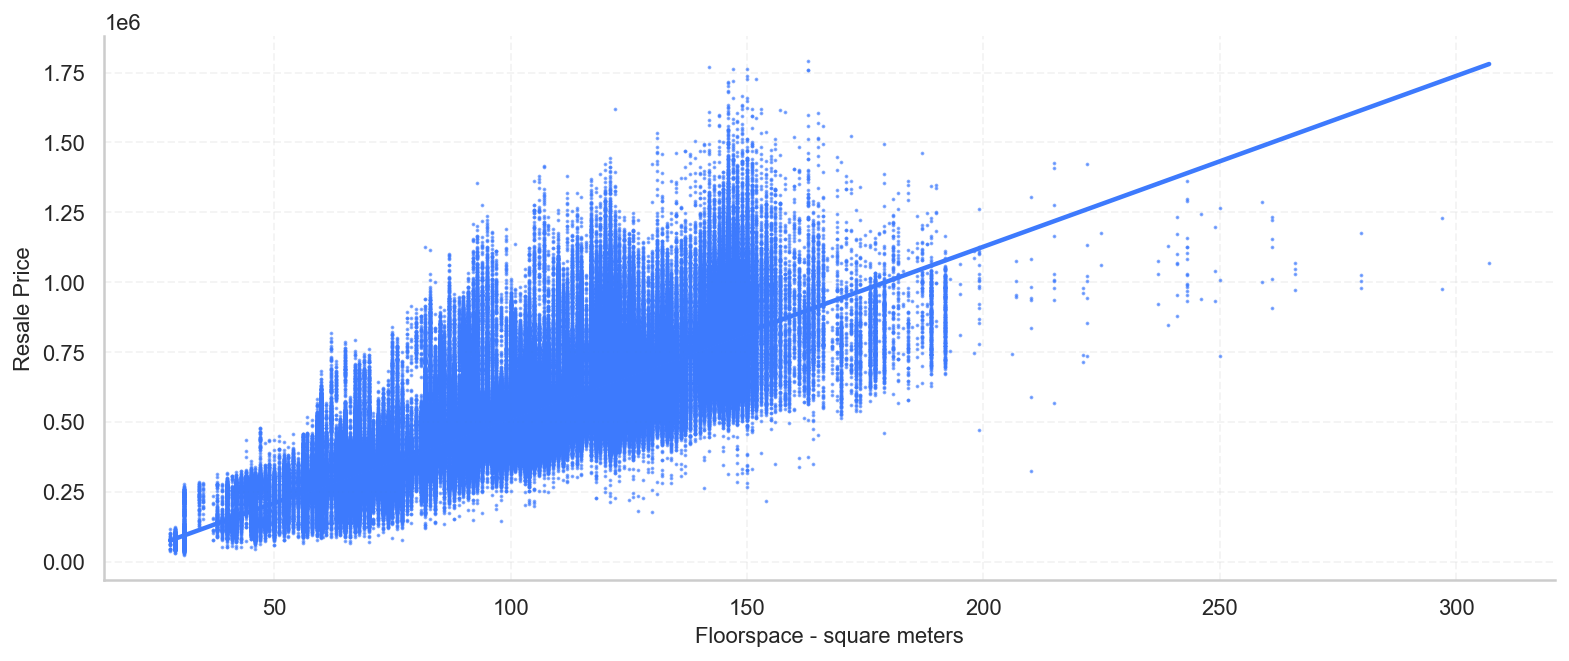

In [85]:
# Visualizing regression models
fig = plt.figure(figsize=(13,5))
p=sns.regplot(x='floor_area_sqm', 
              y='resale_price_norm', 
              data=df, 
              color = 'xkcd:lightish blue', 
              scatter_kws={"s": .75, 'alpha':0.6})
sns.despine()
p.set_ylabel('Resale Price', size=11)
p.set_xlabel('Floorspace - square meters', size=11)
plt.grid(linestyle='--', alpha=0.2)
plt.show();

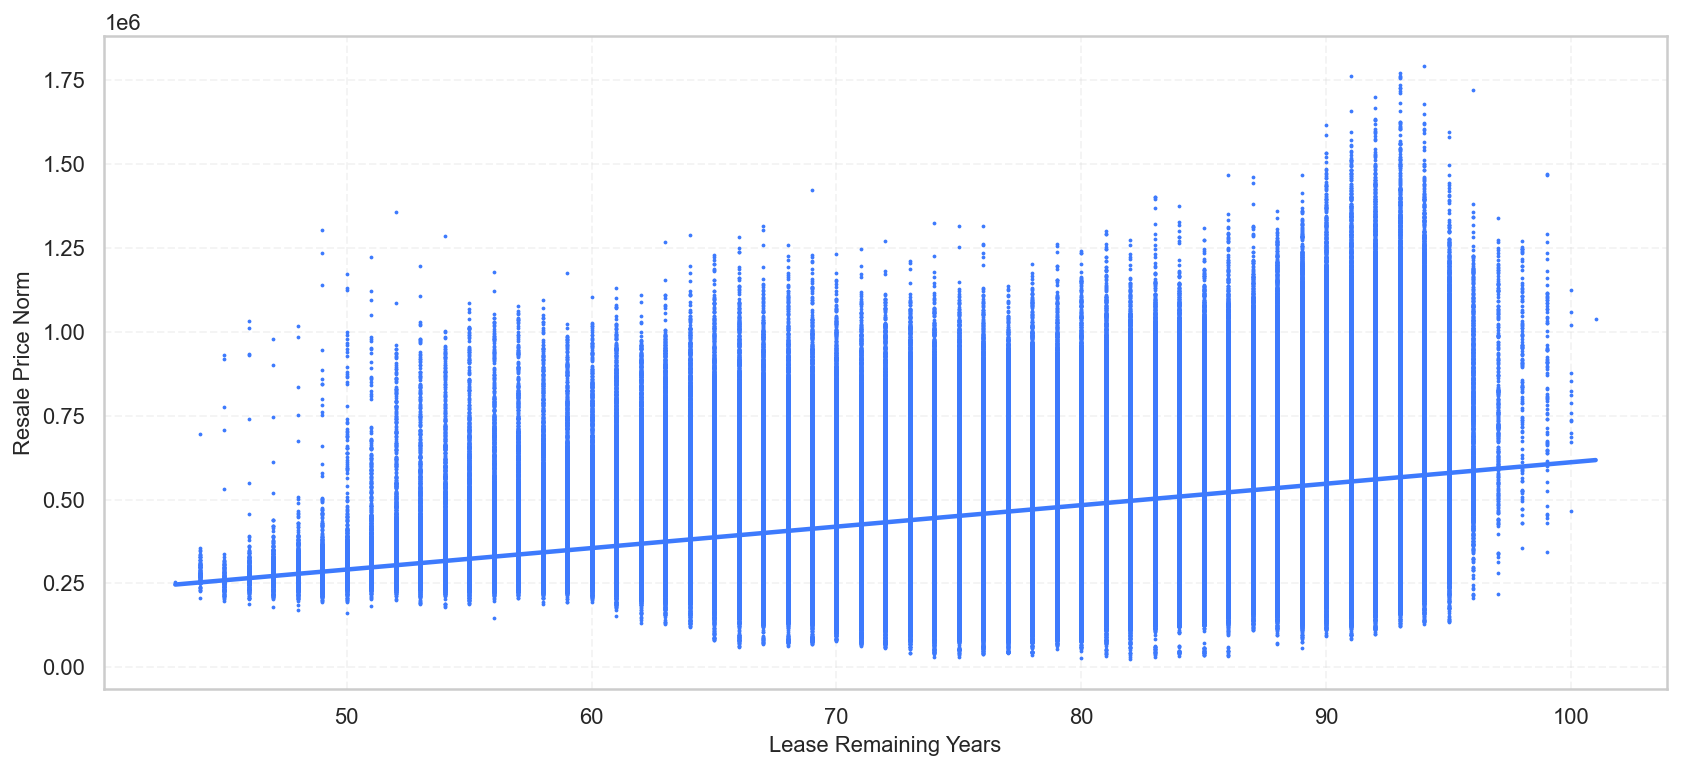

In [86]:
fig = plt.figure(figsize=(14,6))
p=sns.regplot(x='remaining_lease_years', 
              y='resale_price_norm', 
              data=df, 
              color = 'xkcd:lightish blue', 
              scatter_kws={"s": .8, 'alpha':1})
p.set_ylabel('Resale Price Norm', size=11)
p.set_xlabel('Lease Remaining Years', size=11)
plt.grid(linestyle='--', alpha=0.2)
plt.show();

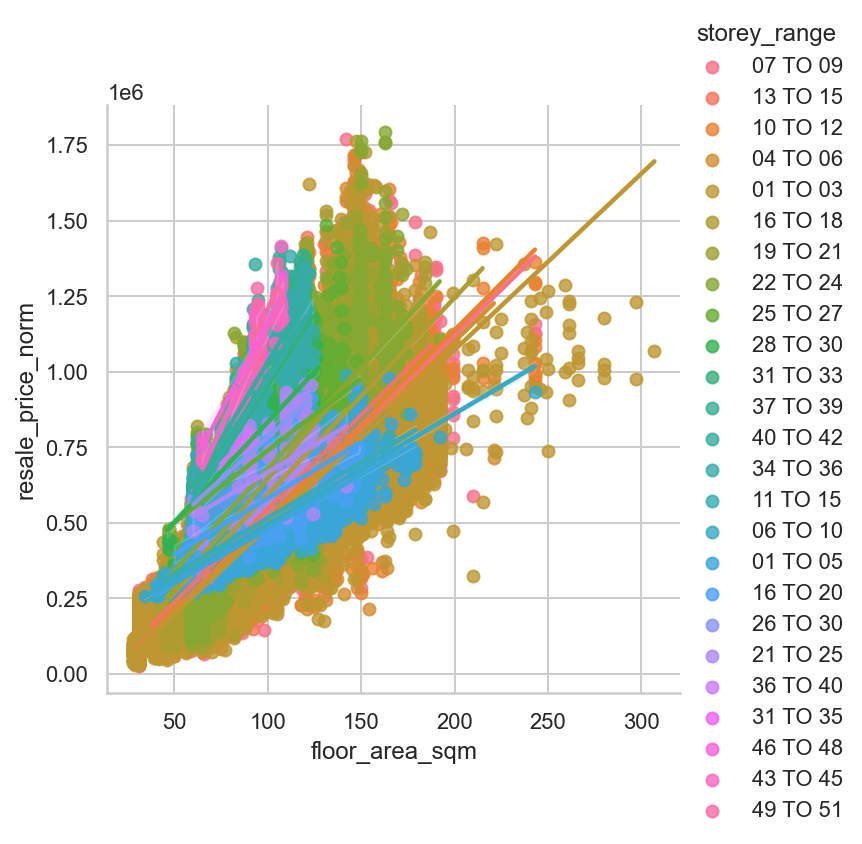

In [87]:
sns.lmplot(x="floor_area_sqm",
           y="resale_price_norm", 
           hue="storey_range", 
           data=df);

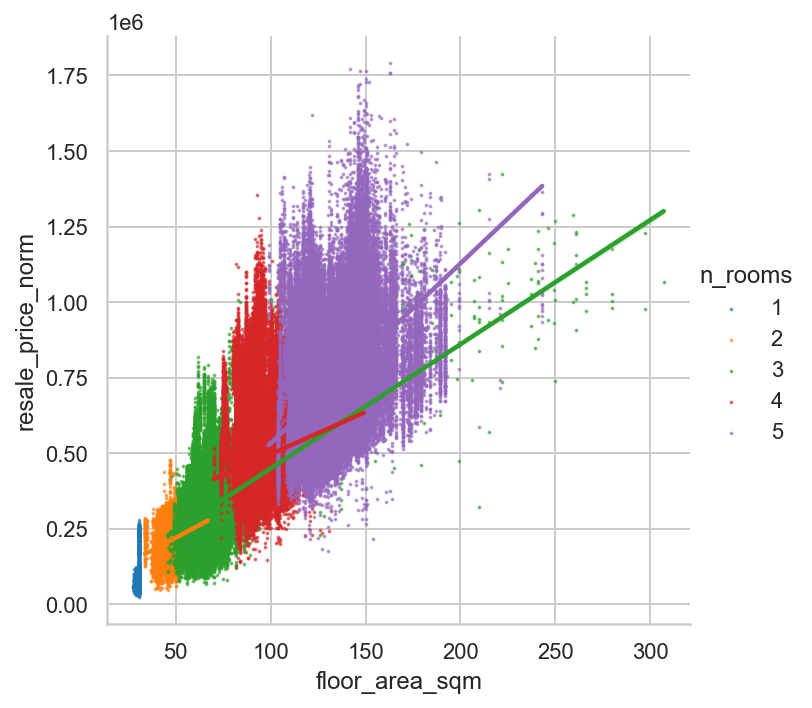

In [88]:
sns.lmplot(x="floor_area_sqm",
           y="resale_price_norm", 
           hue="n_rooms",
           scatter_kws={"s": .8, 'alpha':0.6},
           data=df)
sns.despine()
plt.show();

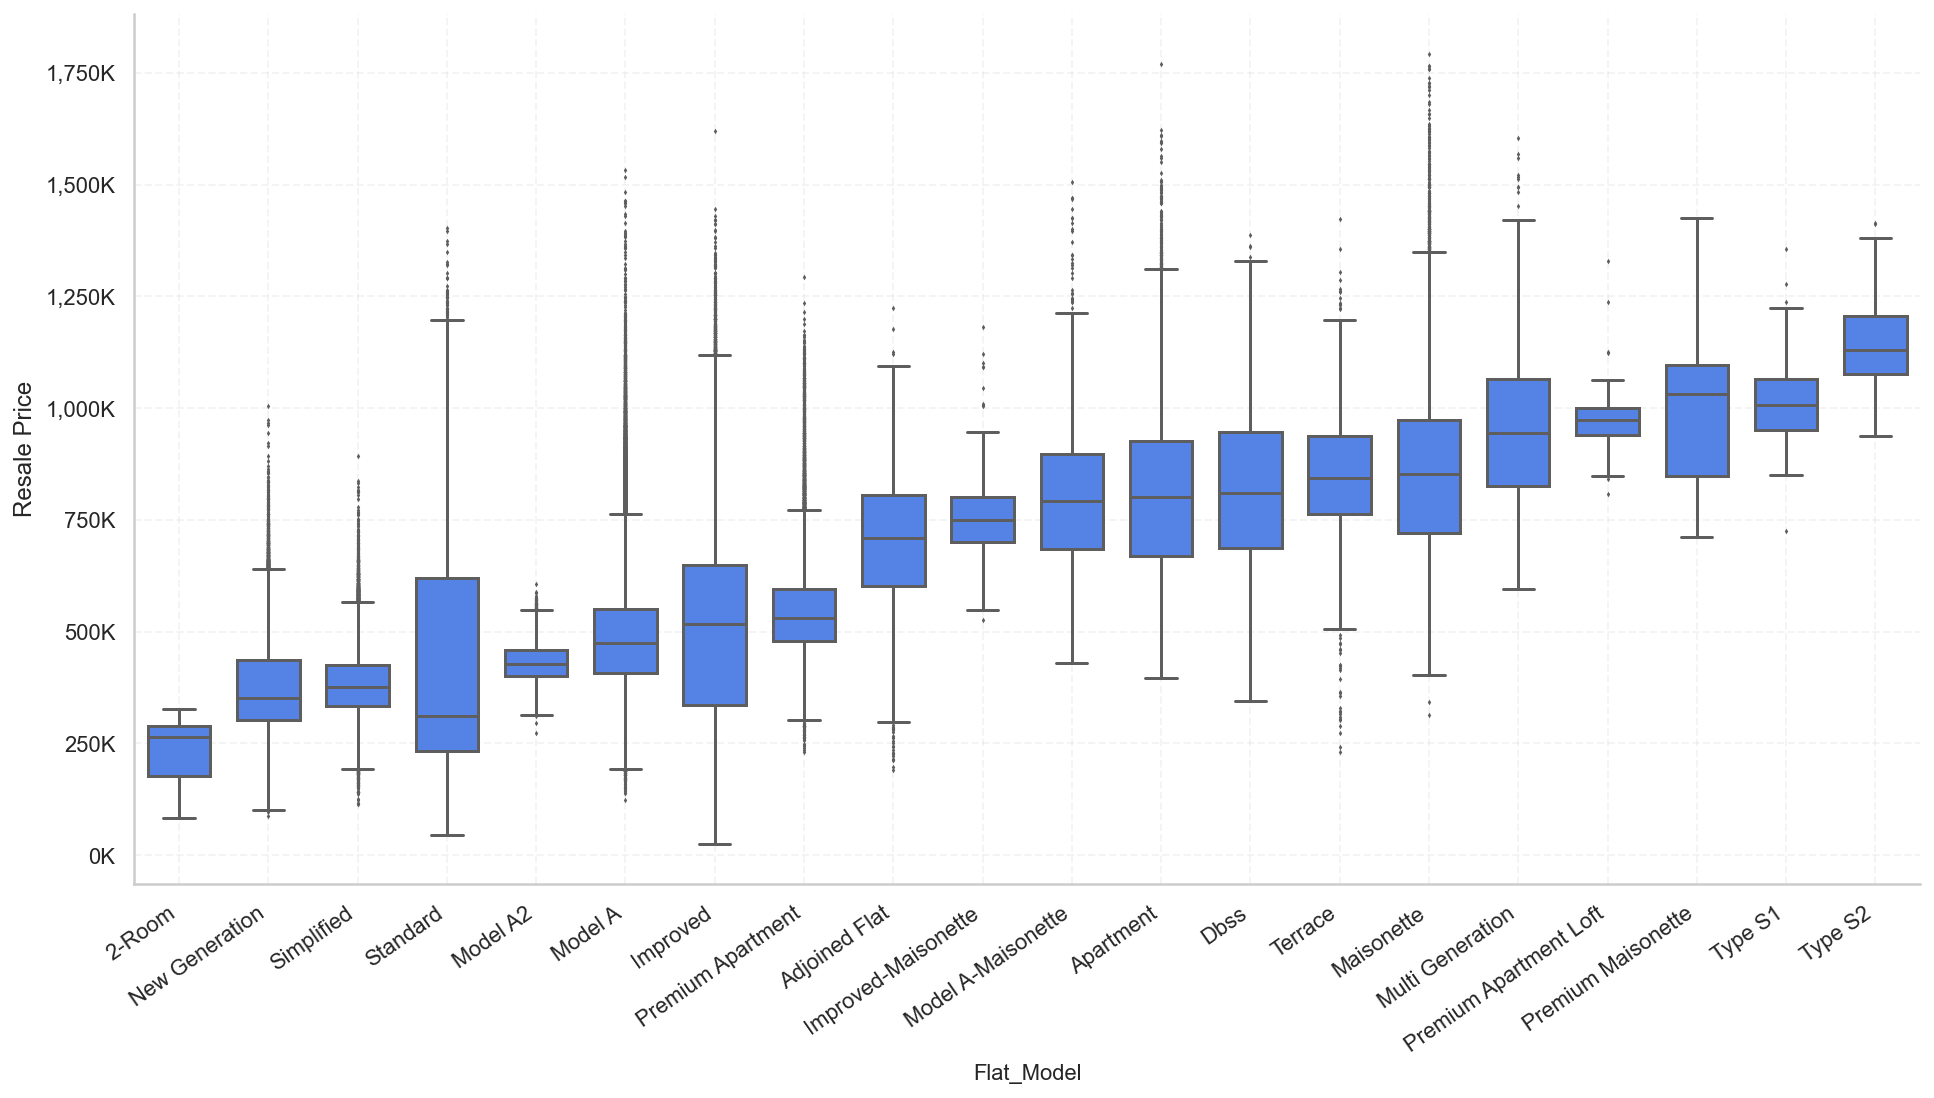

In [89]:
# sb.boxplot(x = 'Value', data = with_merged, flierprops = dict(markerfacecolor = '0.50', markersize = 2))

fig = plt.figure(figsize=(16,8))

p=sns.boxplot(x='flat_model', 
              y='resale_price_norm', 
              data=df, 
              width=0.7,
              flierprops = dict(markersize = .6, markerfacecolor='grey'),
              color = 'xkcd:lightish blue', 
              order=df.groupby('flat_model')['resale_price_norm'].mean().sort_values().reset_index()['flat_model'].tolist())
p.set_xticklabels(p.get_xticklabels(), rotation=35, ha='right')
sns.despine()
p.set_xlabel('Flat_Model', size=11)
ylabels = ['{:,.0f}'.format(x) + 'K' for x in p.get_yticks()/1000]
p.set_yticklabels(ylabels)
p.set_ylabel('Resale Price', size=12)
plt.grid(linestyle='--', alpha=0.2)
plt.show();


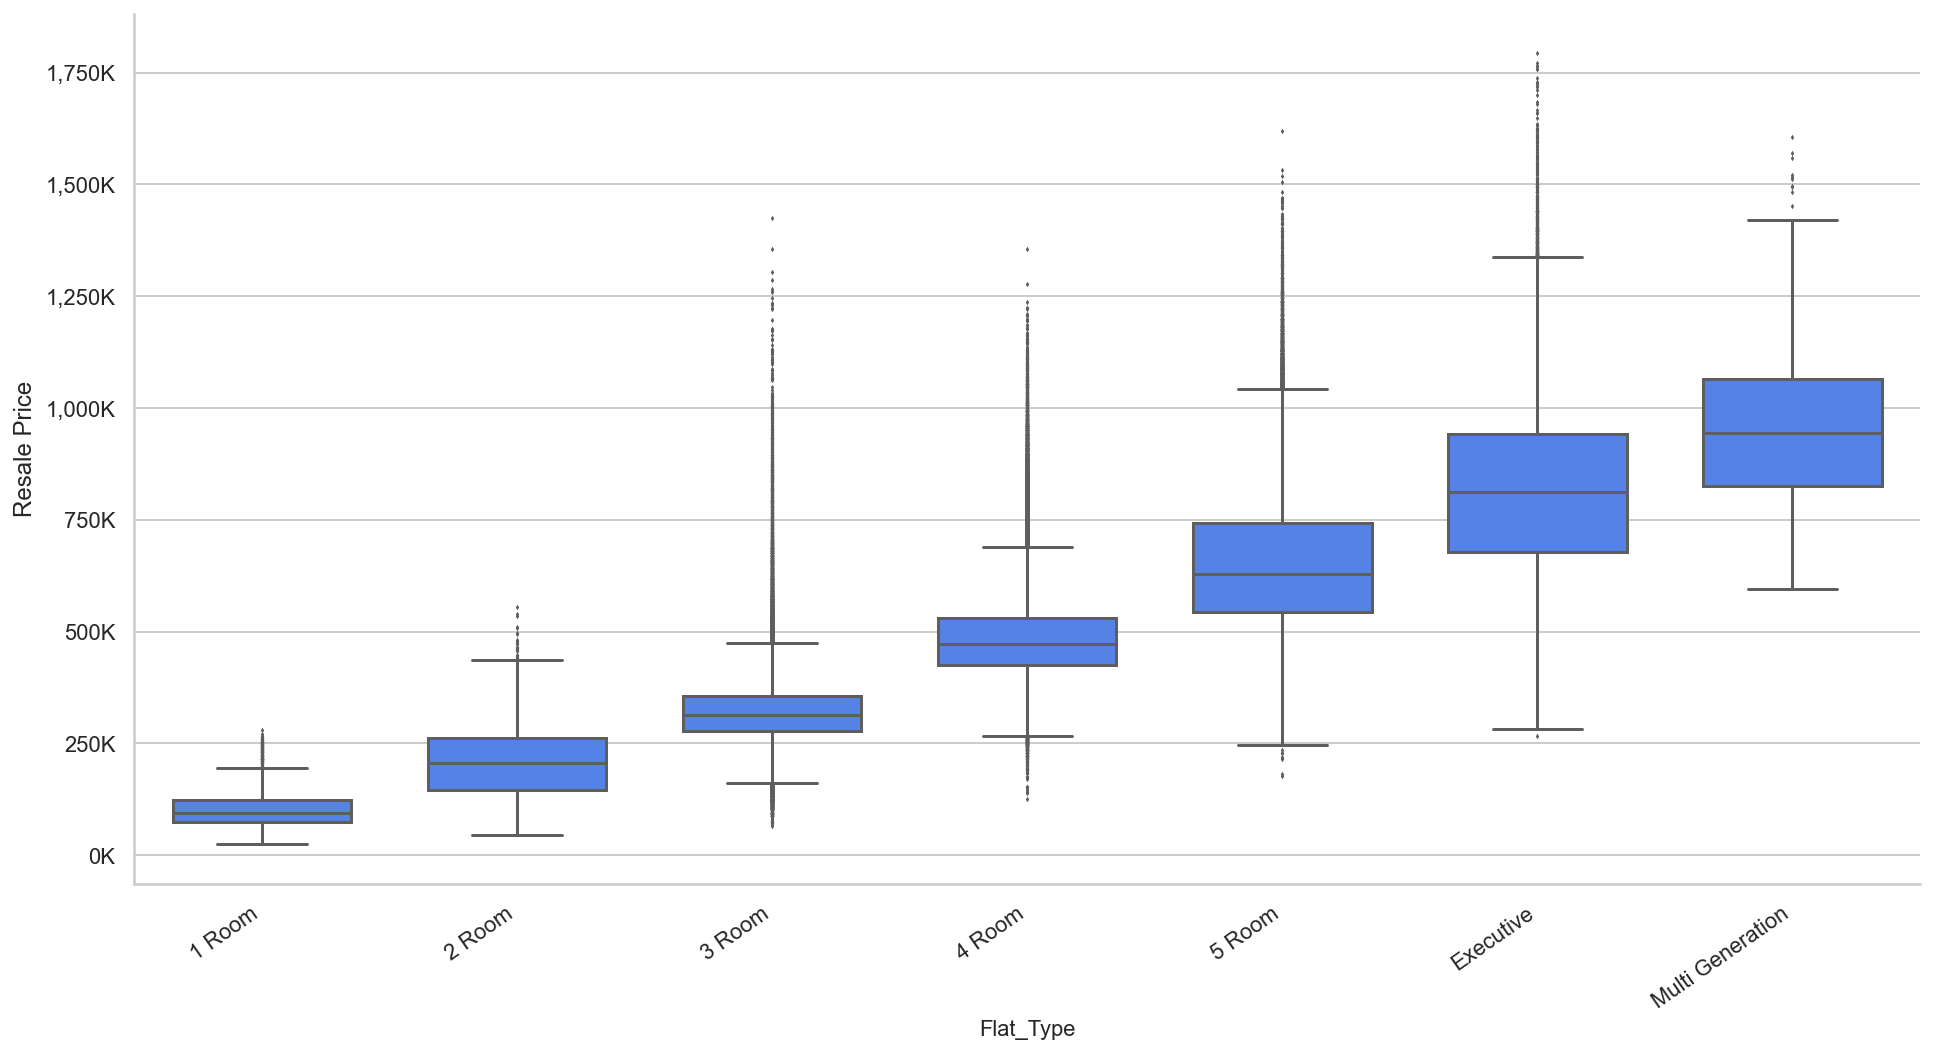

In [90]:

fig = plt.figure(figsize=(16,8))

p=sns.boxplot(x='flat_type', 
              y='resale_price_norm', 
              data=df, 
              width=0.7,
              flierprops = dict(markersize = .6, markerfacecolor='grey'),
              color = 'xkcd:lightish blue', 
              order=df.groupby('flat_type')['resale_price_norm'].mean().sort_values().reset_index()['flat_type'].tolist())

p.set_xticklabels(p.get_xticklabels(), rotation=35, ha='right')
sns.despine()
p.set_xlabel('Flat_Type', size=11)
ylabels = ['{:,.0f}'.format(x) + 'K' for x in p.get_yticks()/1000]
p.set_yticklabels(ylabels)
p.set_ylabel('Resale Price', size=12)
plt.show();


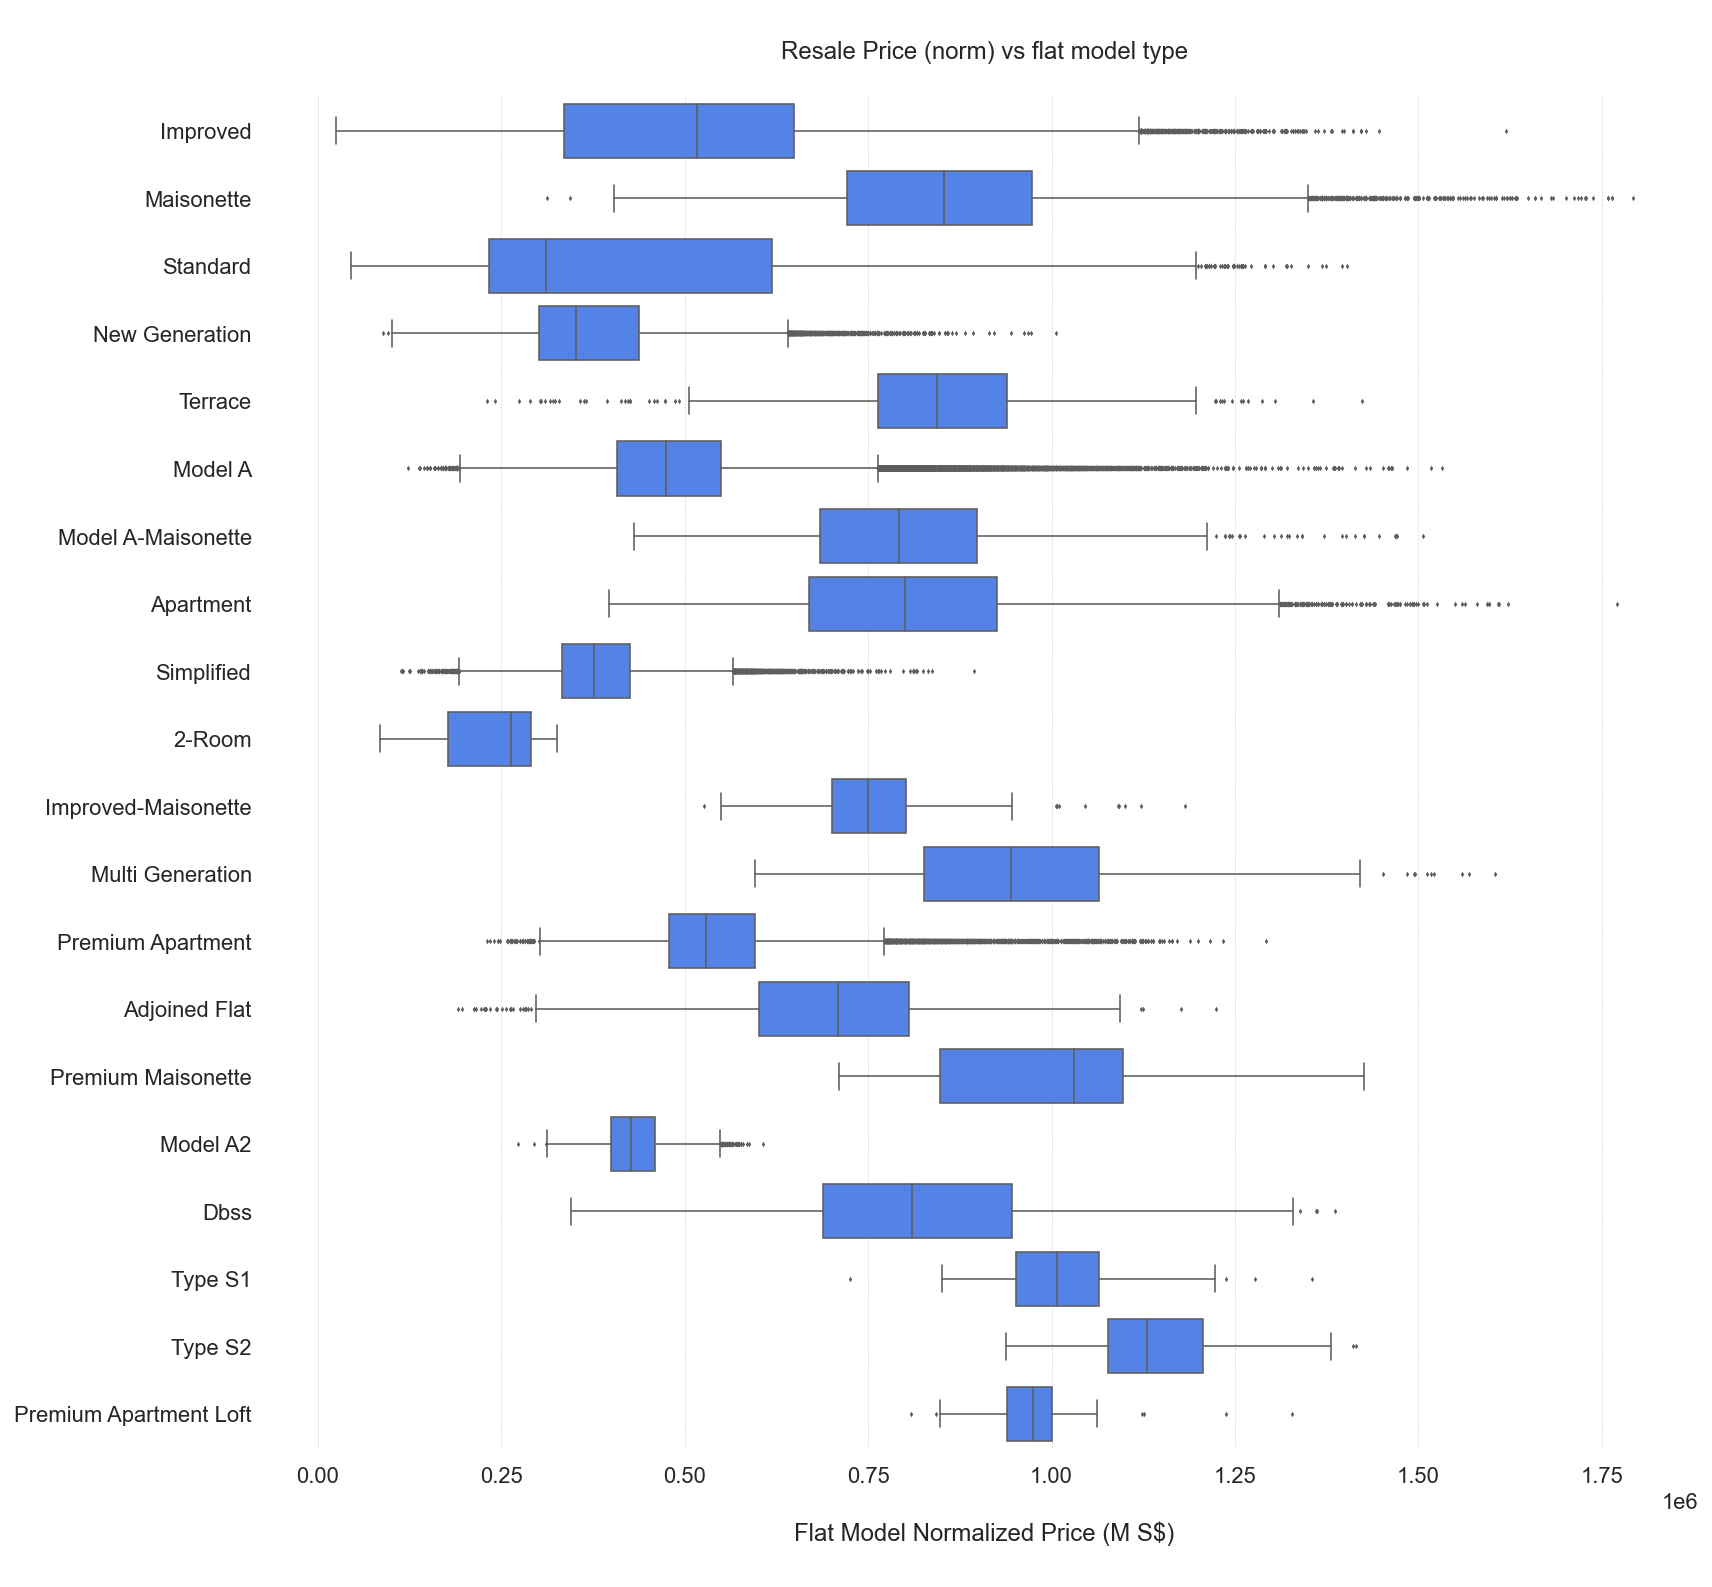

In [91]:
# sns.set_style("ticks", {'grid.linestyle': '--'})
flierprops = dict(markerfacecolor='0.2', 
                  markersize=1,
                  linestyle='none')
fig, ax = plt.subplots(figsize=(12,11))
ax.set_title('\nResale Price (norm) vs flat model type\n', fontsize=12, loc='center')
sns.boxplot(x=df['resale_price_norm'].sort_values(ascending=False),
            y=df['flat_model'],
            ax=ax,
            color = 'xkcd:lightish blue', 
            showfliers=True,
            flierprops = dict(markersize = .6, markerfacecolor='grey'),            
            linewidth=.8)
ax.yaxis.grid(False)   # Show the horizontal gridlines
ax.xaxis.grid(True) 
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 1))
ax.set(xlabel="\nFlat Model Normalized Price (M S$)\n")
sns.despine(top=True, right=True, left=True, bottom=True)
ax.xaxis.set_ticks_position('none') 
ax.set_ylabel('')
ax.grid(linestyle='--', 
        linewidth='0.4', 
        color='lightgray', 
        alpha=0.8,
        axis='x'
       )
# plt.axvline(0, 0,1, linewidth=.4, color="blue", linestyle="--")
plt.tight_layout()
plt.show();
# outliers removed for clarity

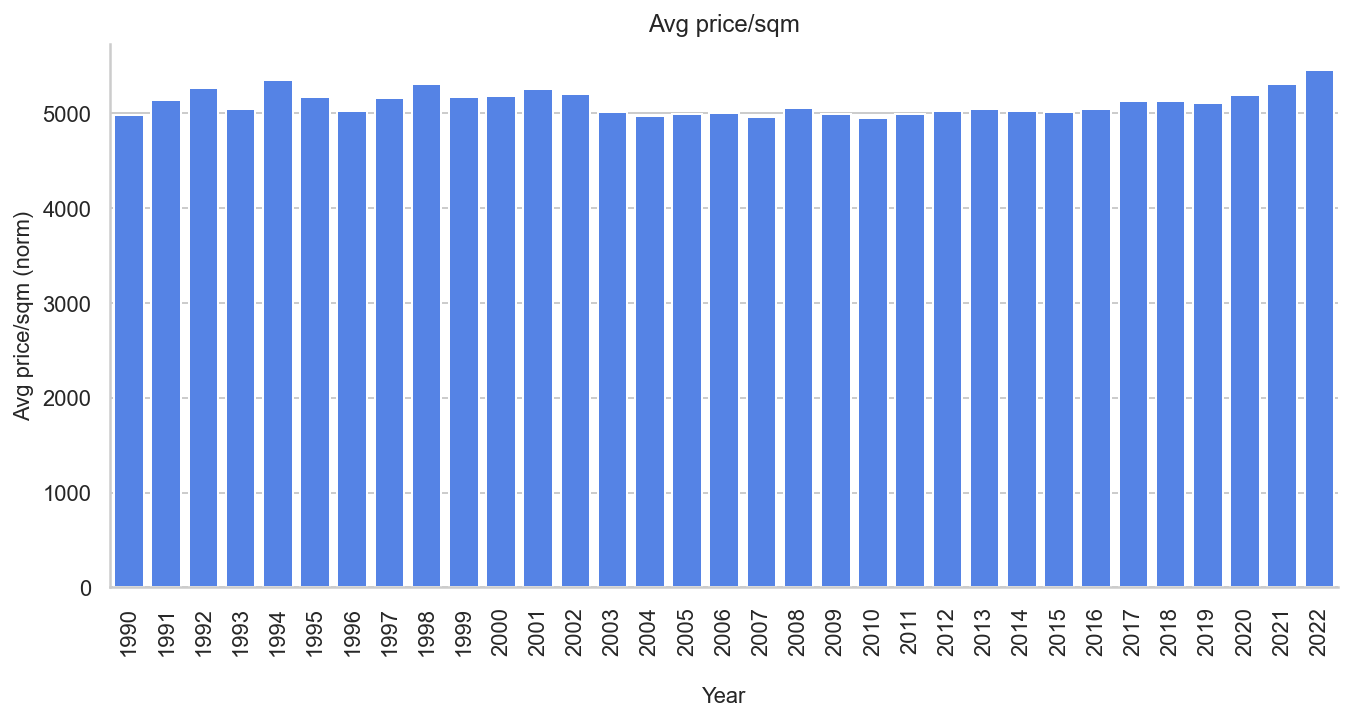

In [92]:
plt.figure(figsize=(11,5))
sales_year = np.unique(pd.DatetimeIndex(df['month']).year.values)
n = len(sales_year)
avg_price = np.zeros(n)
for i in range(0,n):
        price = df['resale_price_norm'][pd.DatetimeIndex(df['month']).year == sales_year[i]].sum()
        sqmm = df['floor_area_sqm'][pd.DatetimeIndex(df['month']).year == sales_year[i]].sum()
        price_f= price/sqmm
        avg_price[i] = price_f
sns.barplot(x=sales_year, y=avg_price, color = 'xkcd:lightish blue', alpha=1)
plt.ylabel('Avg price/sqm (norm)', fontsize=11)
plt.xlabel('\nYear', fontsize=11)
plt.title("Avg price/sqm", fontsize=12)
plt.xticks(rotation='vertical')
sns.despine()
plt.show();

> Note:  This is adjusted (normalized)

*Correlation Plots:*

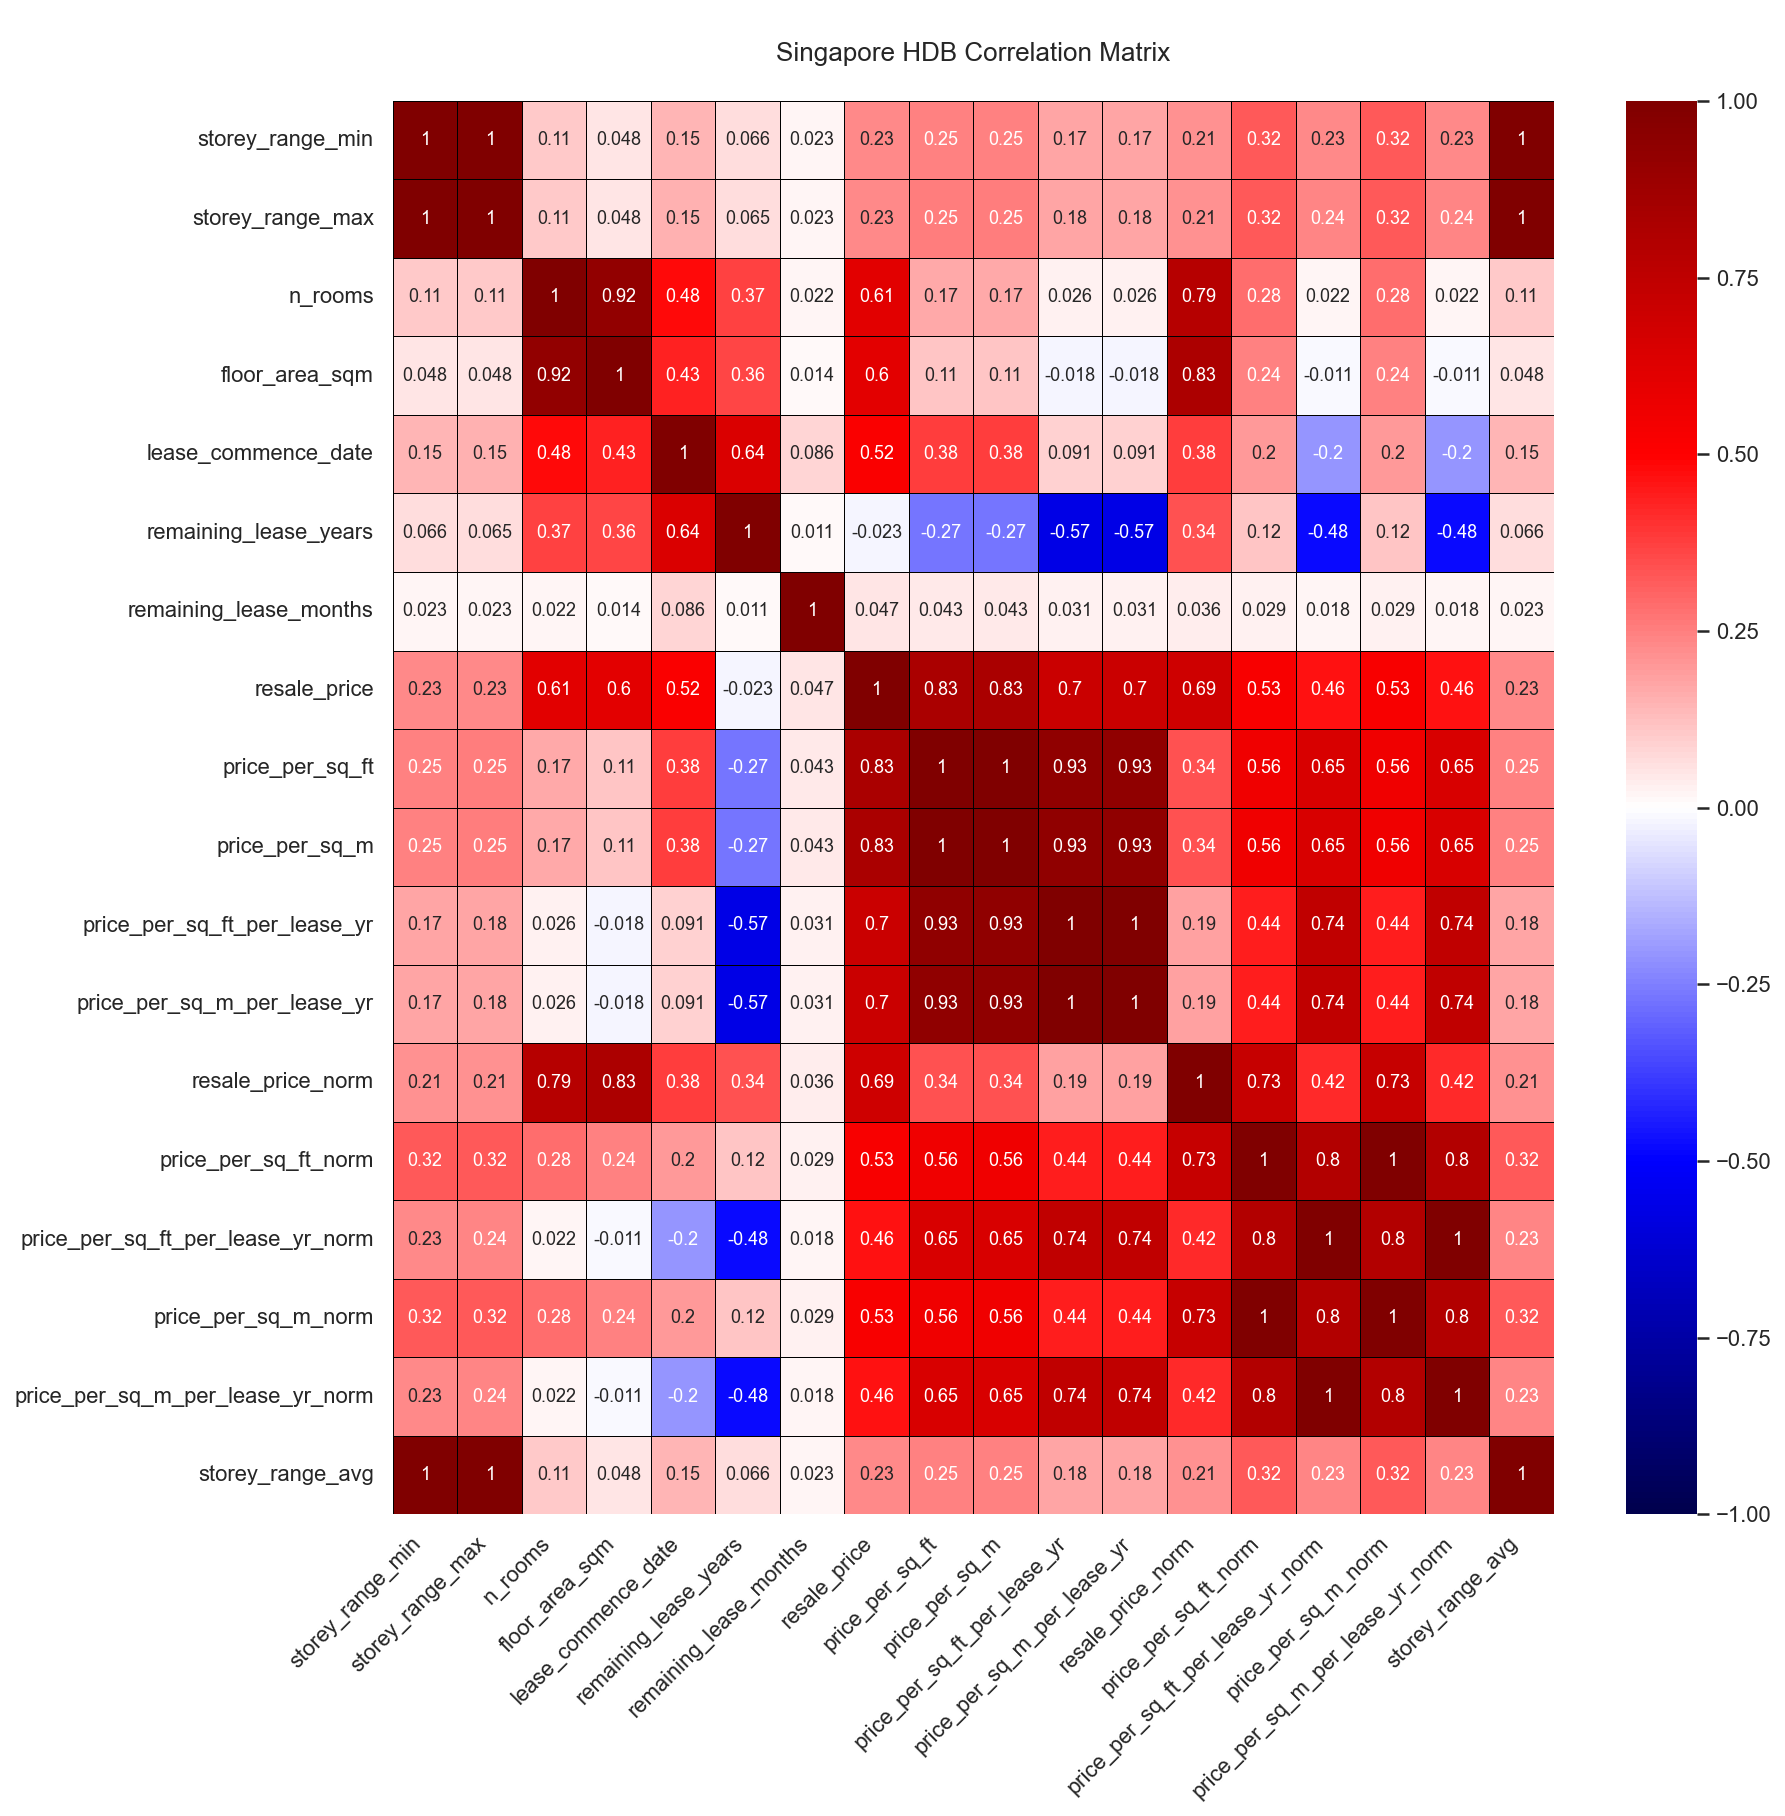

In [93]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(13,13))
sns.heatmap(df.select_dtypes(include=['int64','float64']).corr(), 
                 fmt='.2g', 
                 annot = True, 
                 vmin=-1,
                 vmax=1, 
                 center= 0, 
                 cmap= 'seismic', 
                 linecolor='black', 
                 linewidth=.5, 
                 annot_kws={"size": 9})
plt.xticks(rotation=45, 
           ha='right')

plt.title('\nSingapore HDB Correlation Matrix\n',
          fontsize=13)

# plt.savefig('correlation_matrix_baseline.png', 
#             bbox_inches='tight',
#             pad_inches=0.2, 
#             dpi=400)
fig.show();

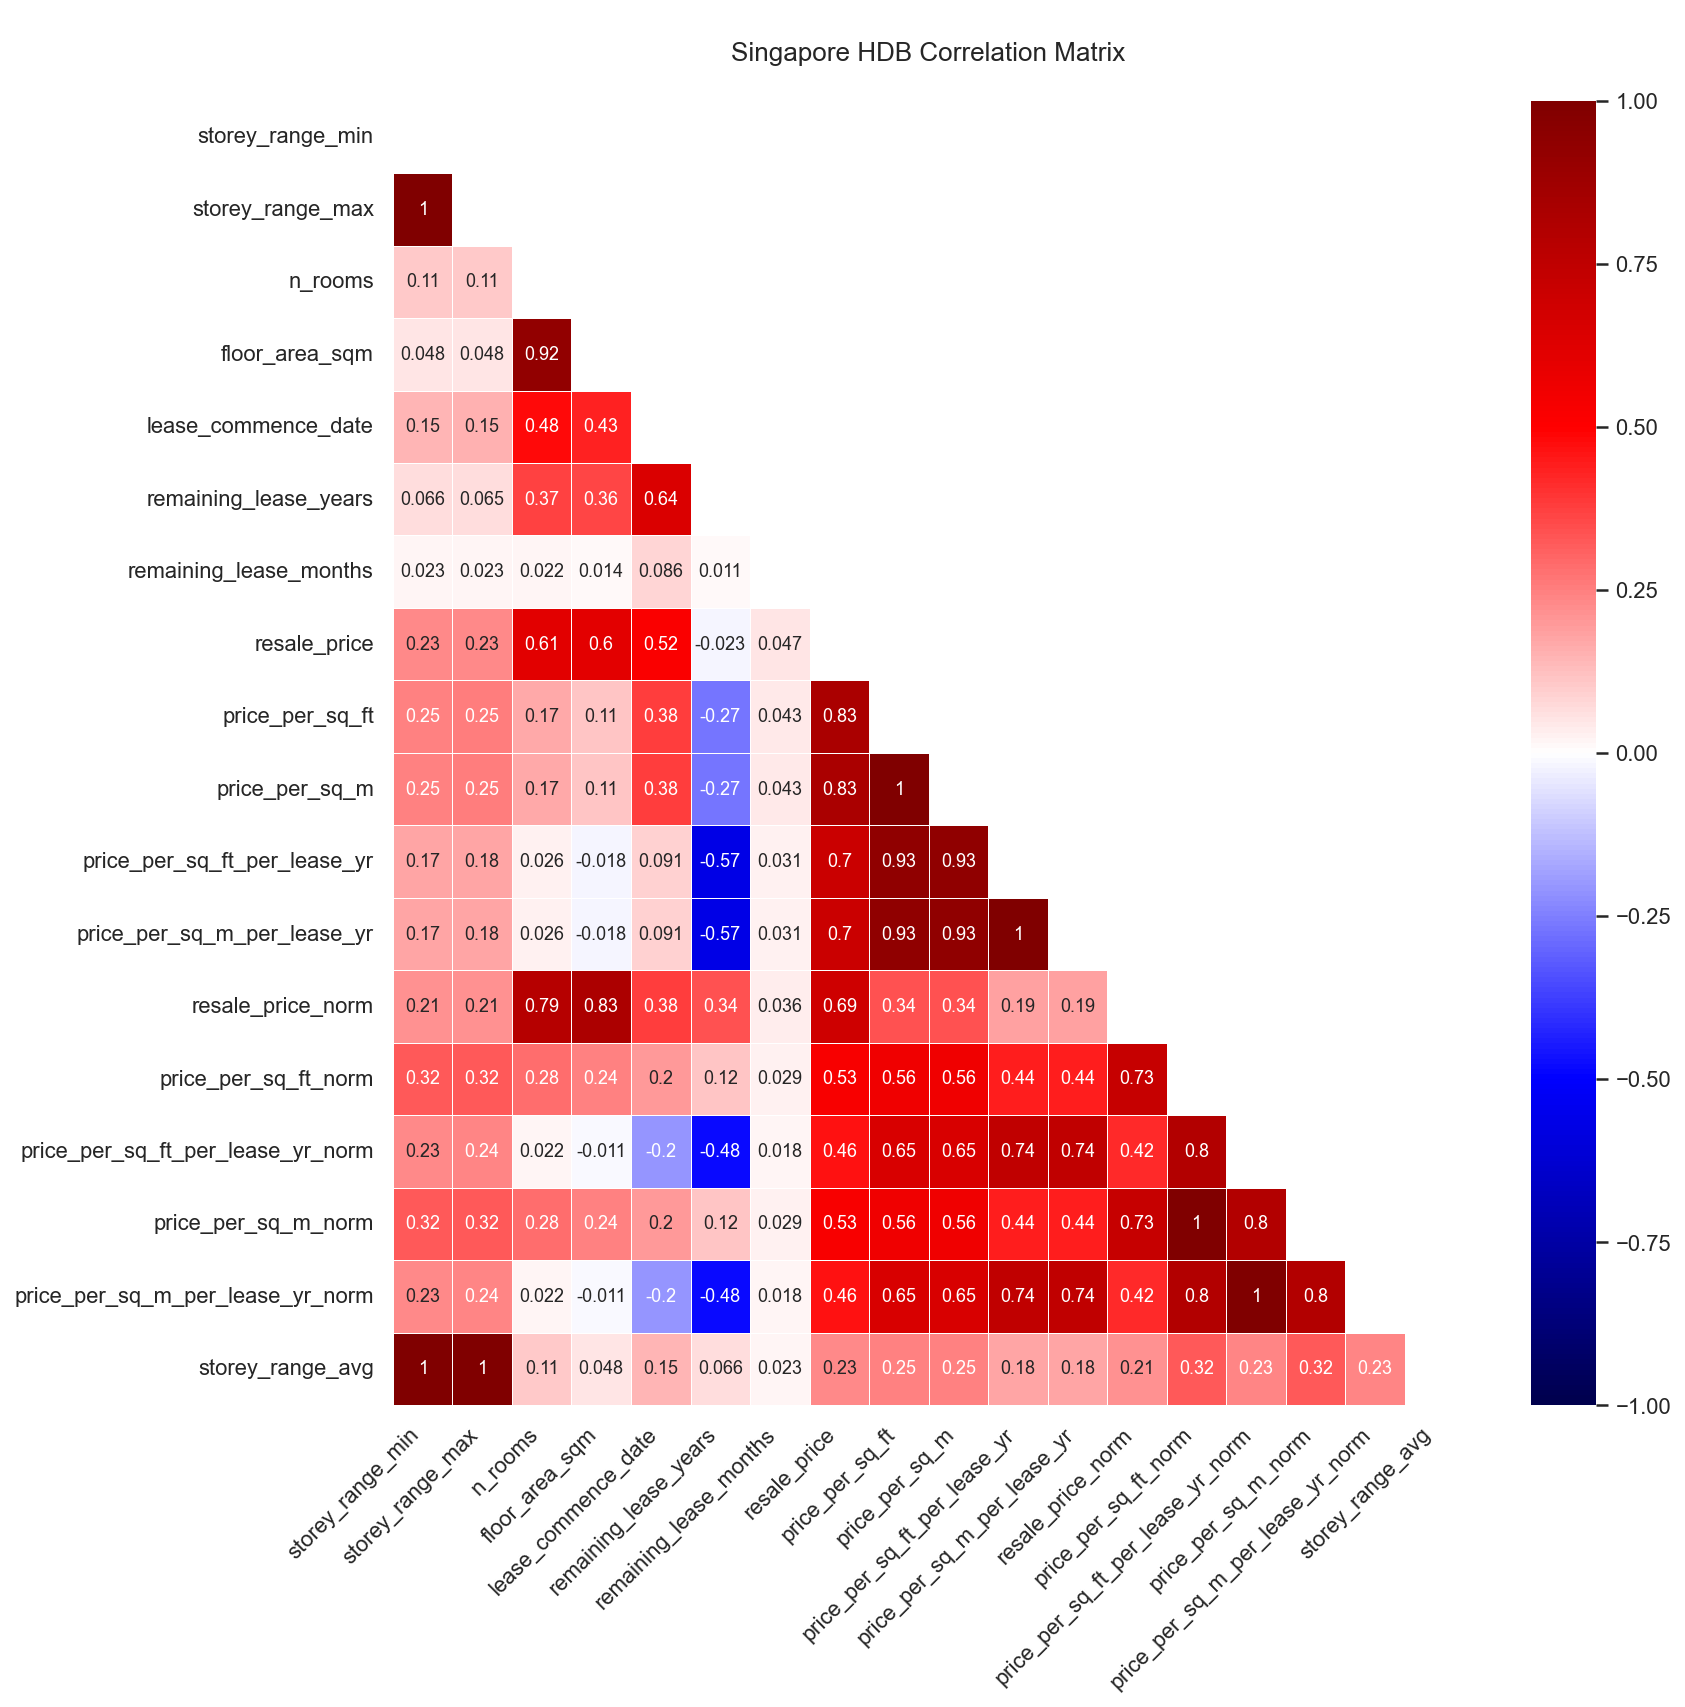

In [94]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['savefig.facecolor']='white'
plt.figure(figsize=(12,12))
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
sns.heatmap(df.select_dtypes(include=['int64','float64']).corr(), 
                 fmt='.2g', 
                 annot = True, 
                 vmin=-1,
                 vmax=1, 
                 mask = mask, 
                 center= 0, 
                 cmap= 'seismic', 
                 linecolor='white', 
                 linewidth=.5, 
                 annot_kws={"size": 9})
plt.xticks(rotation=45, 
           ha='right')
plt.title('\nSingapore HDB Correlation Matrix\n',
          fontsize=13)
plt.savefig('m2_correlation_matrix_baseline_triangular.png', 
            bbox_inches='tight',
            pad_inches=0.2, 
            dpi=600)
fig.show();

In [95]:
display(df.corr())

,storey_range_min,storey_range_max,n_rooms,floor_area_sqm,lease_commence_date,remaining_lease_years,remaining_lease_months,resale_price,price_per_sq_ft,price_per_sq_m,price_per_sq_ft_per_lease_yr,price_per_sq_m_per_lease_yr,resale_price_norm,price_per_sq_ft_norm,price_per_sq_ft_per_lease_yr_norm,price_per_sq_m_norm,price_per_sq_m_per_lease_yr_norm,storey_range_avg
storey_range_min,1.00,1.00,0.11,0.05,0.15,0.07,0.02,0.23,0.25,0.25,0.17,0.17,0.21,0.32,0.23,0.32,0.23,1.00
storey_range_max,1.00,1.00,0.11,0.05,0.15,0.06,0.02,0.23,0.25,0.25,0.18,0.18,0.21,0.32,0.24,0.32,0.24,1.00
n_rooms,0.11,0.11,1.00,0.92,0.48,0.37,0.02,0.61,0.17,0.17,0.03,0.03,0.79,0.28,0.02,0.28,0.02,0.11
floor_area_sqm,0.05,0.05,0.92,1.00,0.43,0.36,0.01,0.60,0.11,0.11,-0.02,-0.02,0.83,0.24,-0.01,0.24,-0.01,0.05
lease_commence_date,0.15,0.15,0.48,0.43,1.00,0.64,0.09,0.52,0.38,0.38,0.09,0.09,0.38,0.20,-0.20,0.20,-0.20,0.15
remaining_lease_years,0.07,0.06,0.37,0.36,0.64,1.00,0.01,-0.02,-0.27,-0.27,-0.57,-0.57,0.34,0.12,-0.48,0.12,-0.48,0.07
remaining_lease_months,0.02,0.02,0.02,0.01,0.09,0.01,1.00,0.05,0.04,0.04,0.03,0.03,0.04,0.03,0.02,0.03,0.02,0.02
resale_price,0.23,0.23,0.61,0.60,0.52,-0.02,0.05,1.00,0.83,0.83,0.70,0.70,0.69,0.53,0.46,0.53,0.46,0.23
price_per_sq_ft,0.25,0.25,0.17,0.11,0.38,-0.27,0.04,0.83,1.00,1.00,0.93,0.93,0.34,0.56,0.65,0.56,0.65,0.25
price_per_sq_m,0.25,0.25,0.17,0.11,0.38,-0.27,0.04,0.83,1.00,1.00,0.93,0.93,0.34,0.56,0.65,0.56,0.65,0.25


In [96]:
# let's rank from highest to lowest (comparing to our price_per_sq_m_norm feature)
correlations = df.corr()
correlations = correlations[['price_per_sq_m_norm']].sort_values(by='price_per_sq_m_norm', 
                                                                 ascending=False)
print(correlations.to_string())

                                   price_per_sq_m_norm
price_per_sq_m_norm                               1.00
price_per_sq_ft_norm                              1.00
price_per_sq_ft_per_lease_yr_norm                 0.80
price_per_sq_m_per_lease_yr_norm                  0.80
resale_price_norm                                 0.73
price_per_sq_ft                                   0.56
price_per_sq_m                                    0.56
resale_price                                      0.53
price_per_sq_m_per_lease_yr                       0.44
price_per_sq_ft_per_lease_yr                      0.44
storey_range_max                                  0.32
storey_range_avg                                  0.32
storey_range_min                                  0.32
n_rooms                                           0.28
floor_area_sqm                                    0.24
lease_commence_date                               0.20
remaining_lease_years                             0.12
remaining_

In [97]:
# compare correlations to price_per_sq_m_norm...
cm = sns.light_palette("blue", as_cmap=True)
correlations.style.set_caption('Correlation Values Ranked').background_gradient(cmap=cm)

,price_per_sq_m_norm
price_per_sq_m_norm,1.000000
price_per_sq_ft_norm,1.000000
price_per_sq_ft_per_lease_yr_norm,0.799873
price_per_sq_m_per_lease_yr_norm,0.799873
resale_price_norm,0.726422
price_per_sq_ft,0.558838
price_per_sq_m,0.558838
resale_price,0.527309
price_per_sq_m_per_lease_yr,0.443894
price_per_sq_ft_per_lease_yr,0.443894


> This makes sense.  price_per_sq_ft_norm should be 100% correlated with price_per_sq_m_norm, etc.  Any correlation higher than 0.80 is a measure of collinearity.  Some features are mathematically derived from others at this point, to be filtered later